In [1]:
%load_ext autoreload
%autoreload 2

In [31]:
from copy import deepcopy

import imodels

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from tqdm import tqdm

import shap

In [17]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
X, y, cols = imodels.util.data_util.get_clean_dataset("breast_cancer", "imodels")
cols = np.array(cols)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=50)

In [5]:
idx_all = list(range(X_train.shape[0]))
idx_train, idx_test = train_test_split(idx_all, test_size=0.33)
X_t, X_v, y_t, y_v = X_train[idx_train], X_train[idx_test], y_train[idx_train], y_train[idx_test]

In [15]:
RF = RandomForestClassifier(n_estimators=50)
RF.fit(X_t, y_t)
hsRF = imodels.HSTreeClassifierCV(deepcopy(RF))
hsRF.fit(X_t, y_t)

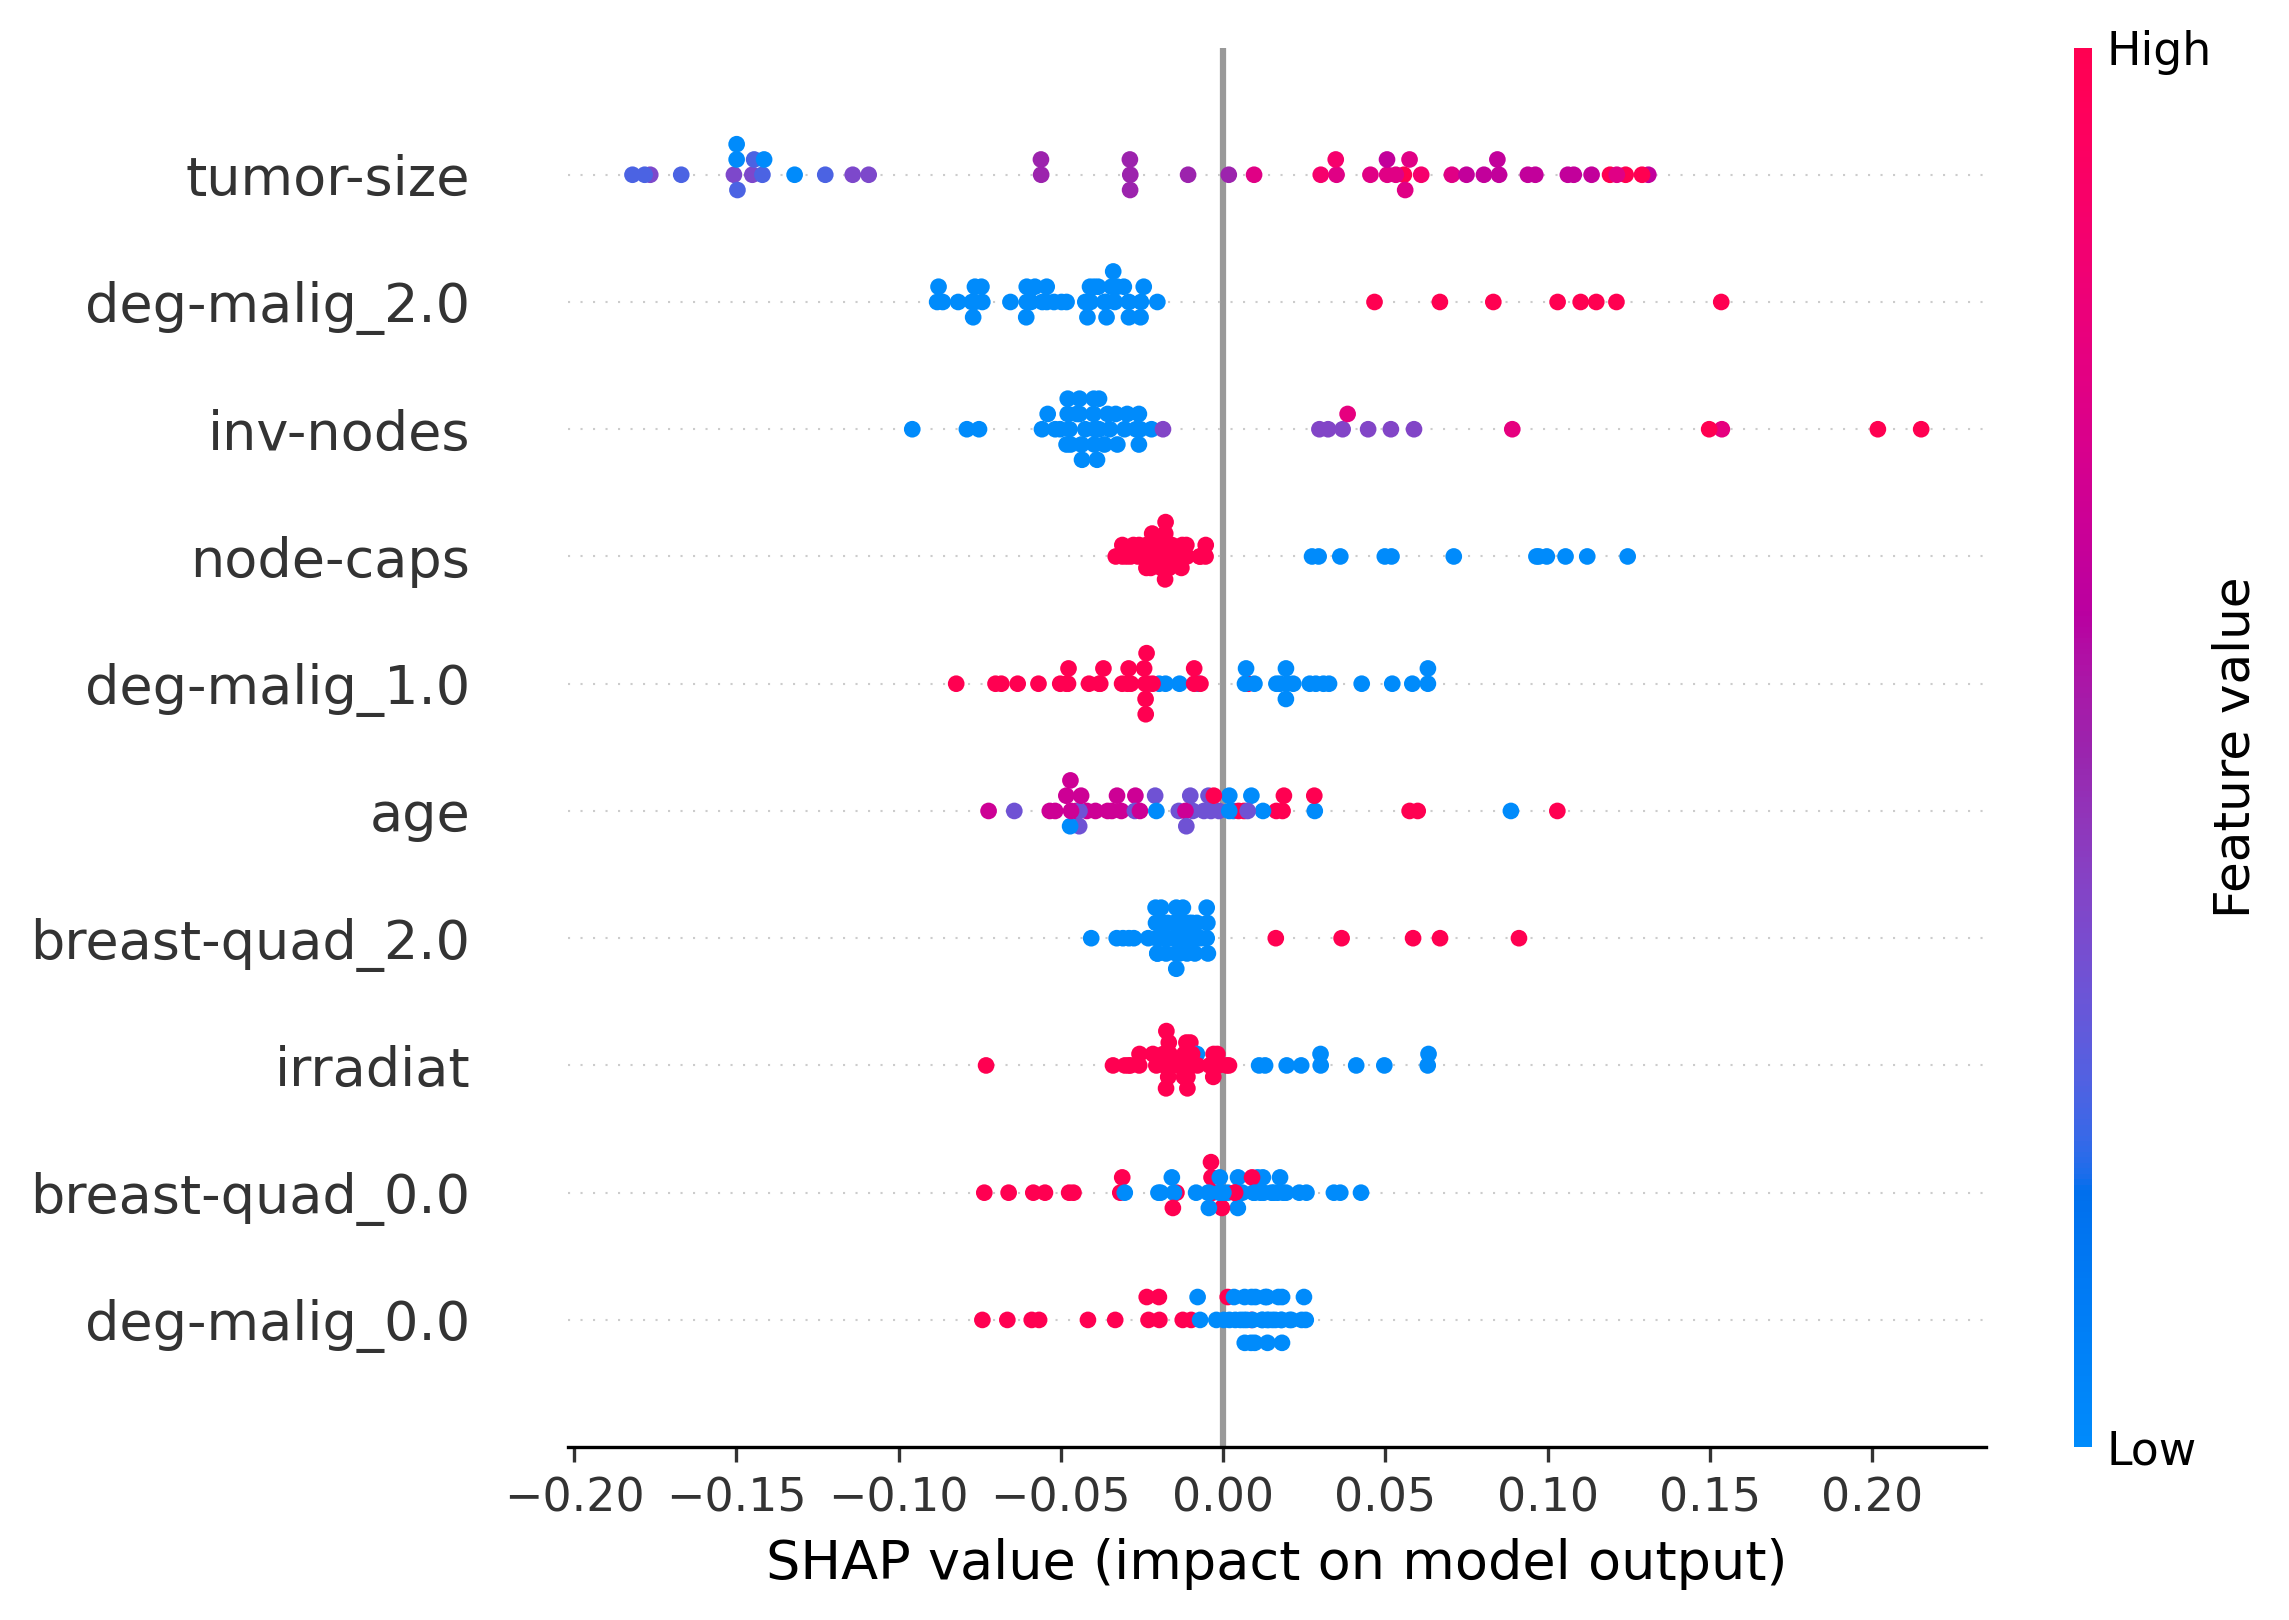

In [23]:
shap_values = shap.TreeExplainer(RF).shap_values(X_test)[1]
shap.summary_plot(shap_values, X_test, feature_names=cols, max_display=10)

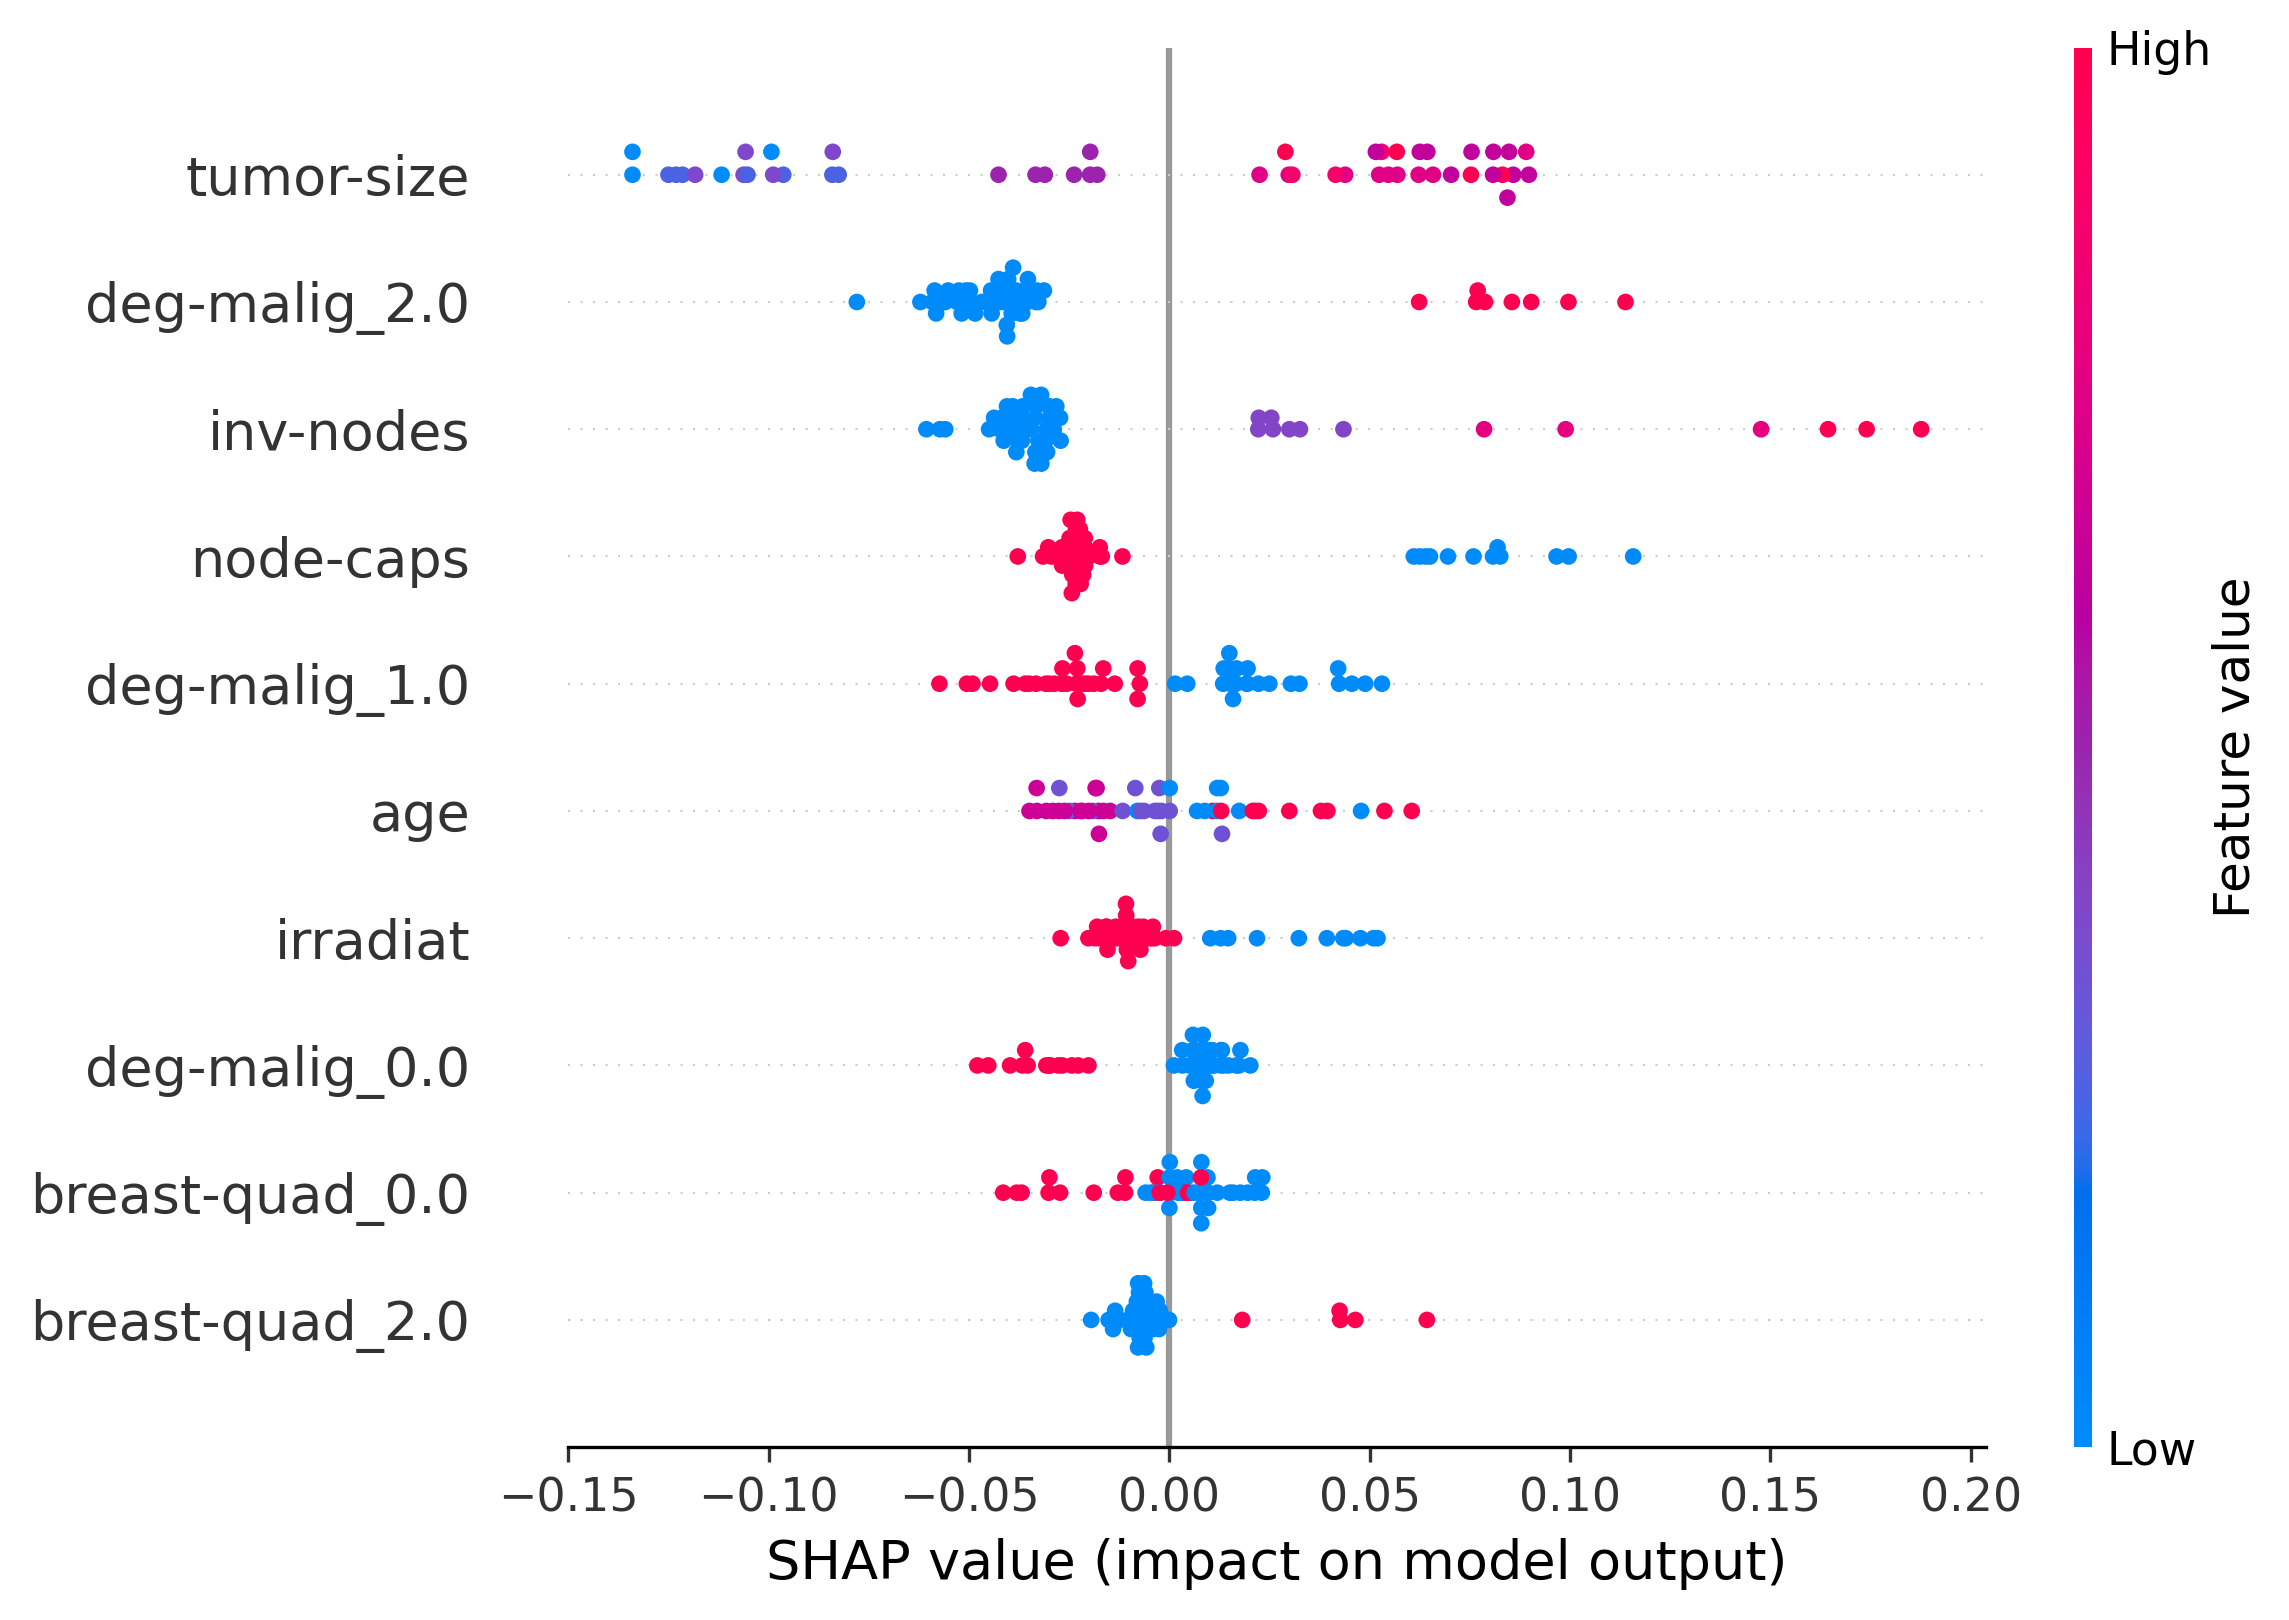

In [24]:
shap_values = shap.TreeExplainer(hsRF.estimator_).shap_values(X_test)[1]
shap.summary_plot(shap_values, X_test, feature_names=cols, max_display=10)

In [28]:
shap_values.std(axis=0)

array([0.02356489, 0.07879799, 0.06121097, 0.04494584, 0.01371827,
       0.0204354 , 0.00130675, 0.00863272, 0.01148819, 0.01551858,
       0.00667804, 0.01616756, 0.0096222 , 0.01152105, 0.0195806 ,
       0.02856724, 0.04916048])

In [34]:
variance_RF = np.zeros(len(cols))
variance_hsRF = np.zeros(len(cols))

idx_all = list(range(X_train.shape[0]))

N = 100

for _ in tqdm(range(N)):
    idx_train, _ = train_test_split(idx_all, test_size=0.33)
    X_t, y_t = X_train[idx_train], y_train[idx_train]
    
    RF = RandomForestClassifier(n_estimators=50)
    RF.fit(X_t, y_t)
    hsRF = imodels.HSTreeClassifierCV(deepcopy(RF))
    hsRF.fit(X_t, y_t)
    
    shap_values_RF = shap.TreeExplainer(RF).shap_values(X_test)[1]
    variance_RF += shap_values_RF.std(axis=0)
    shap_values_hsRF = shap.TreeExplainer(hsRF.estimator_).shap_values(X_test)[1]
    variance_hsRF += shap_values_hsRF.std(axis=0)

variance_RF /= N
variance_hsRF /= N

100%|██████████████████████████████████████████| 10/10 [00:24<00:00,  2.45s/it]


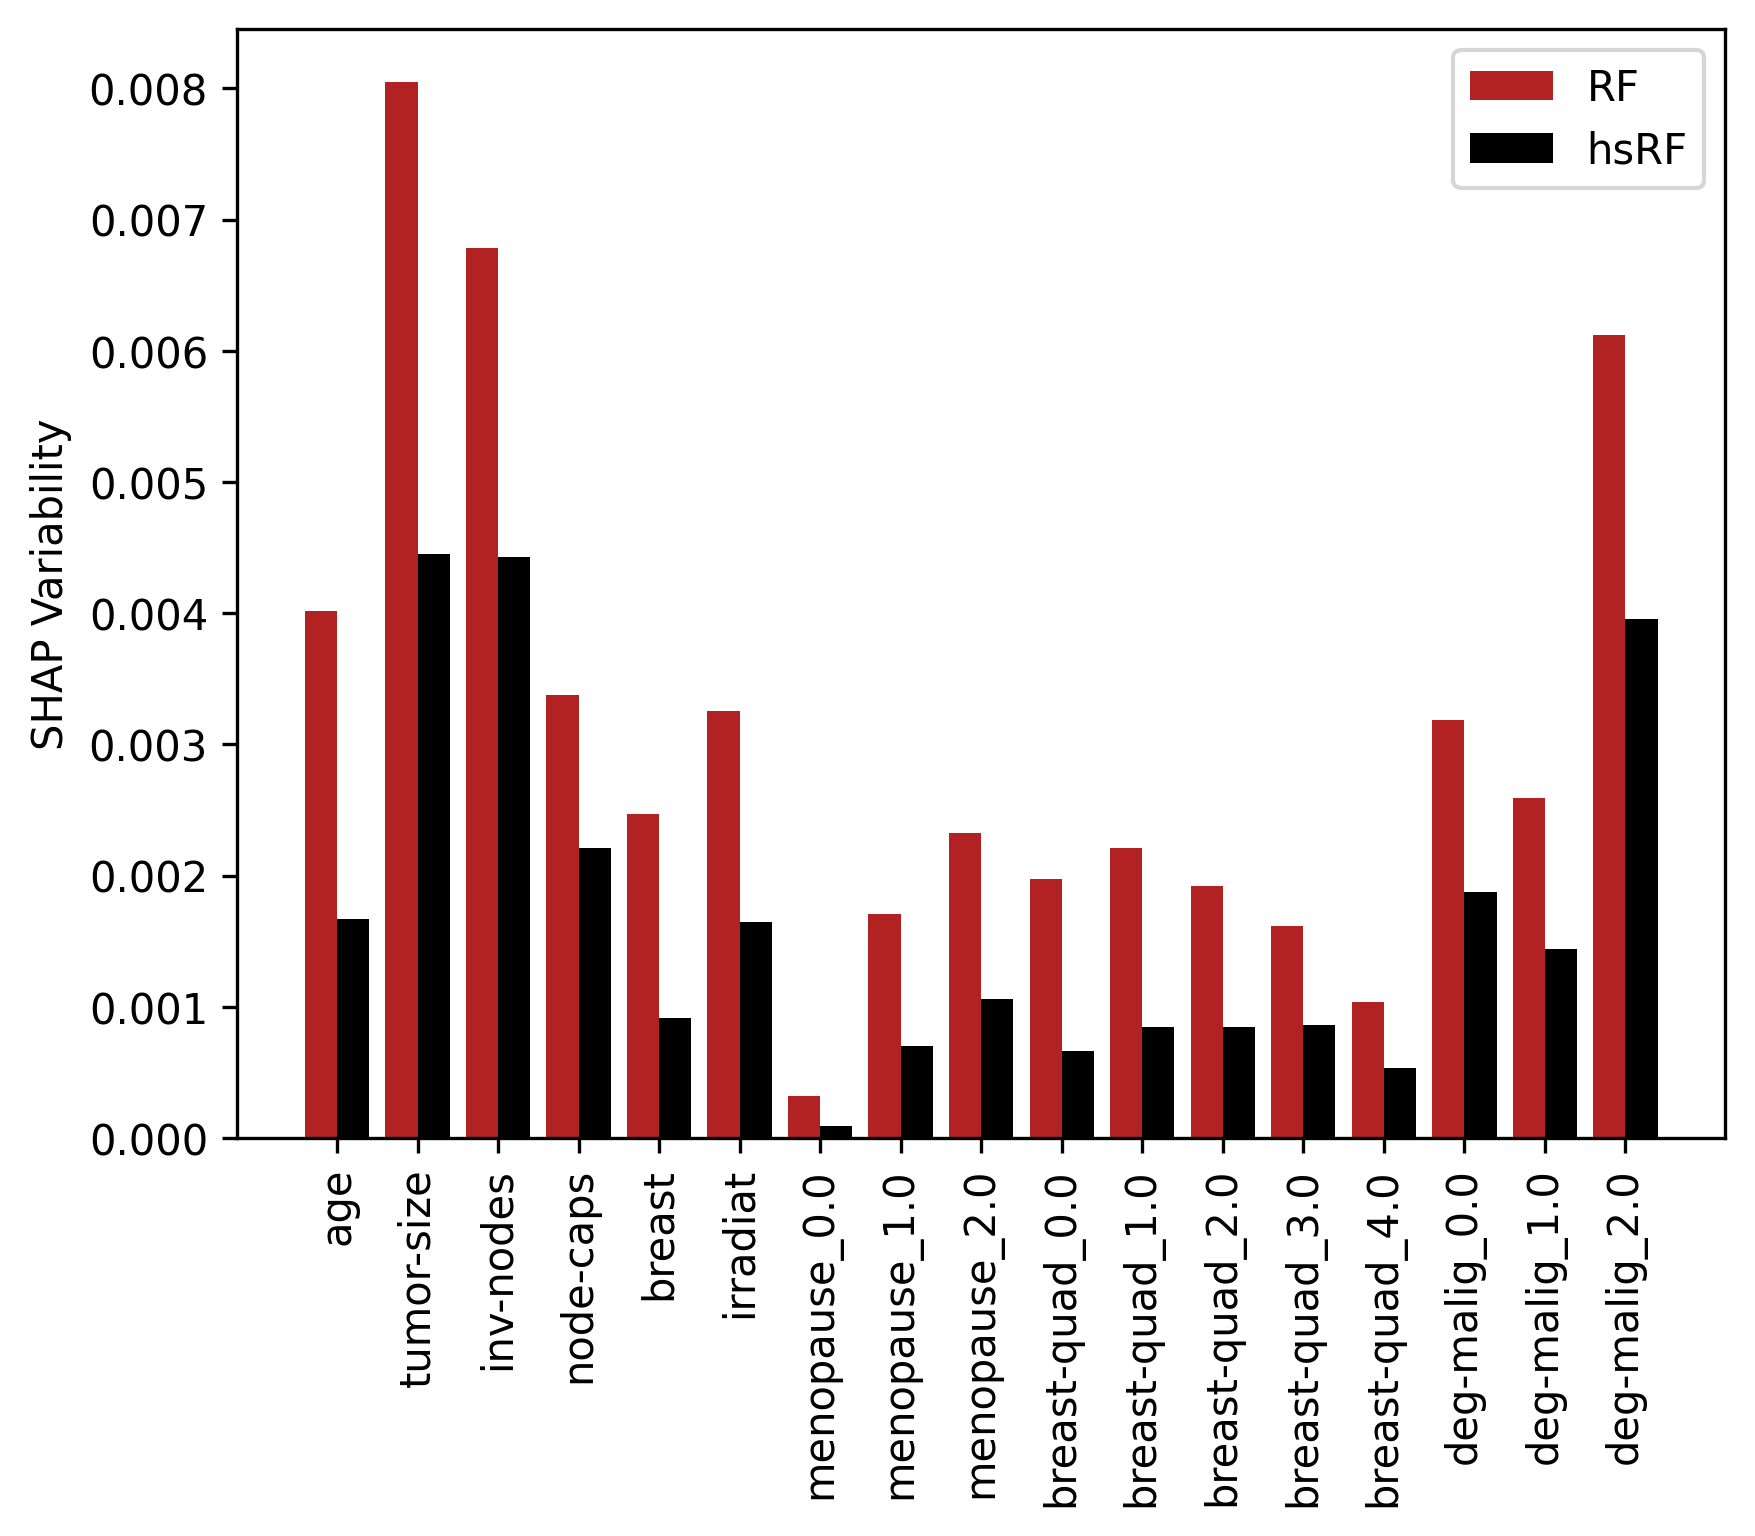

In [53]:
xaxis = np.array(range(variance_RF.shape[0]))
plt.bar(xaxis-0.2, variance_RF, width=0.4, color="firebrick", label="RF")
plt.bar(xaxis+0.2, variance_hsRF, width=0.4, color="black", label="hsRF")
plt.xticks(xaxis, cols, rotation=90)
plt.legend()
plt.ylabel("SHAP Variability")
print()

In [68]:
def feature_variability(dataset_name, database_name, N=100, save=False):
    X, y, cols = imodels.util.data_util.get_clean_dataset(dataset_name, database_name)
    cols = np.array(cols)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=50)

    variance_RF = np.zeros(len(cols))
    variance_hsRF = np.zeros(len(cols))
    idx_all = list(range(X_train.shape[0]))

    for _ in tqdm(range(N)):
        idx_train, _ = train_test_split(idx_all, test_size=0.33)
        X_t, y_t = X_train[idx_train], y_train[idx_train]

        RF = RandomForestClassifier(n_estimators=50)
        RF.fit(X_t, y_t)
        hsRF = imodels.HSTreeClassifierCV(deepcopy(RF))
        hsRF.fit(X_t, y_t)

        shap_values_RF = shap.TreeExplainer(RF).shap_values(X_test)[1]
        variance_RF += shap_values_RF.std(axis=0)
        shap_values_hsRF = shap.TreeExplainer(hsRF.estimator_).shap_values(X_test)[1]
        variance_hsRF += shap_values_hsRF.std(axis=0)

    variance_RF /= N
    variance_hsRF /= N
    
    xaxis = np.array(range(variance_RF.shape[0]))
    fig = plt.figure(dataset_name)
    plt.clf()
    plt.bar(xaxis-0.2, variance_RF, width=0.4, color="firebrick", label="RF")
    plt.bar(xaxis+0.2, variance_hsRF, width=0.4, color="black", label="hsRF")
    plt.xticks(xaxis, cols, rotation=90)
    plt.legend()
    plt.ylabel("SHAP Variability")
    if save:
        plt.savefig("../figures/SHAP_variability/c_"+dataset_name, bbox_inches="tight", facecolor="white", edgecolor="auto")

100%|████████████████████████████████████████████| 5/5 [00:12<00:00,  2.42s/it]


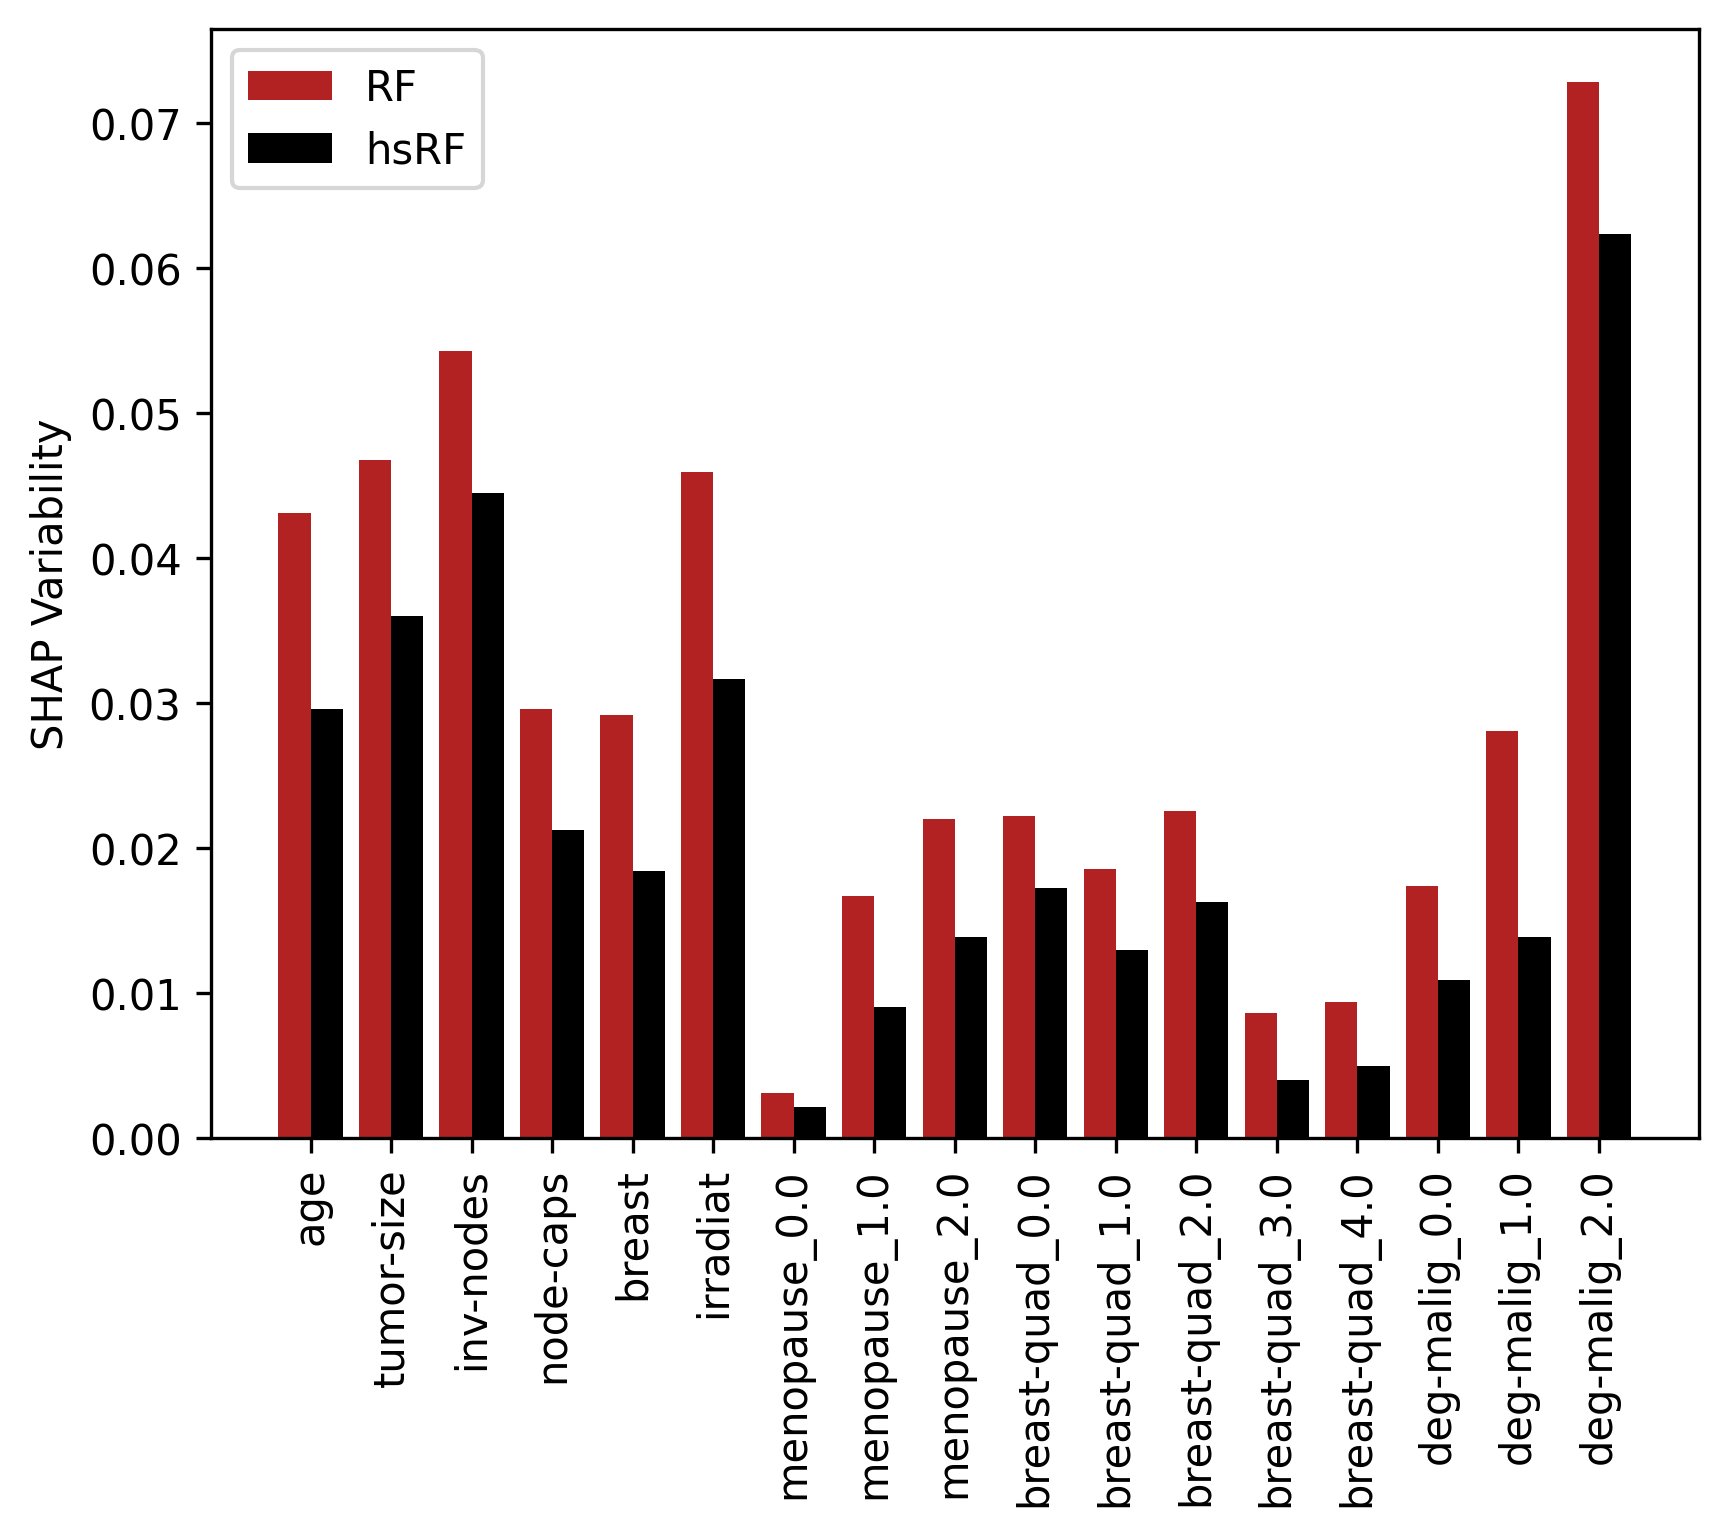

In [65]:
feature_variability("breast_cancer", "imodels", N=5, save=False)

100%|██████████████████████████████████████| 100/100 [1:00:50<00:00, 36.51s/it]


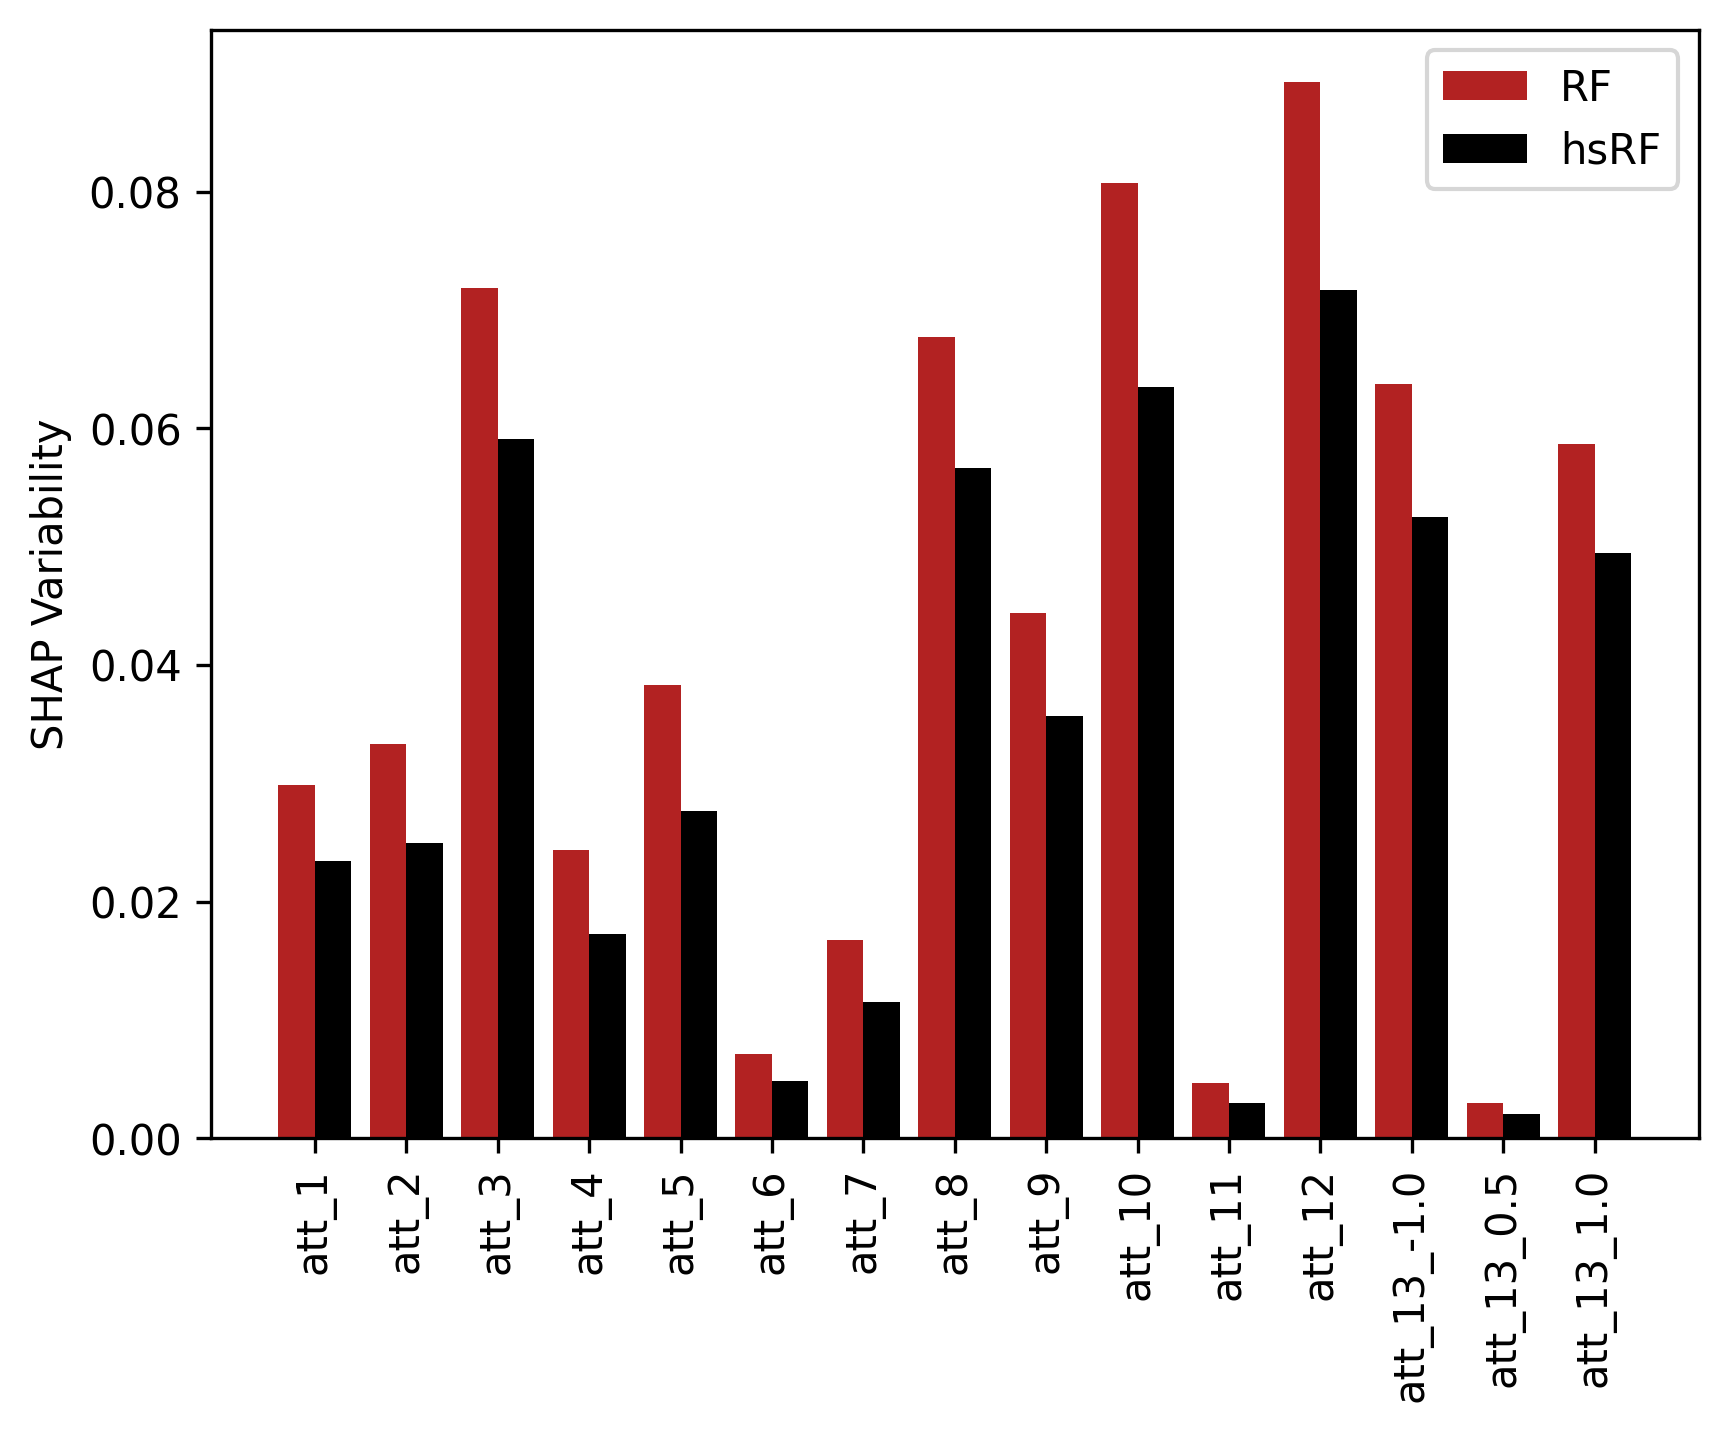

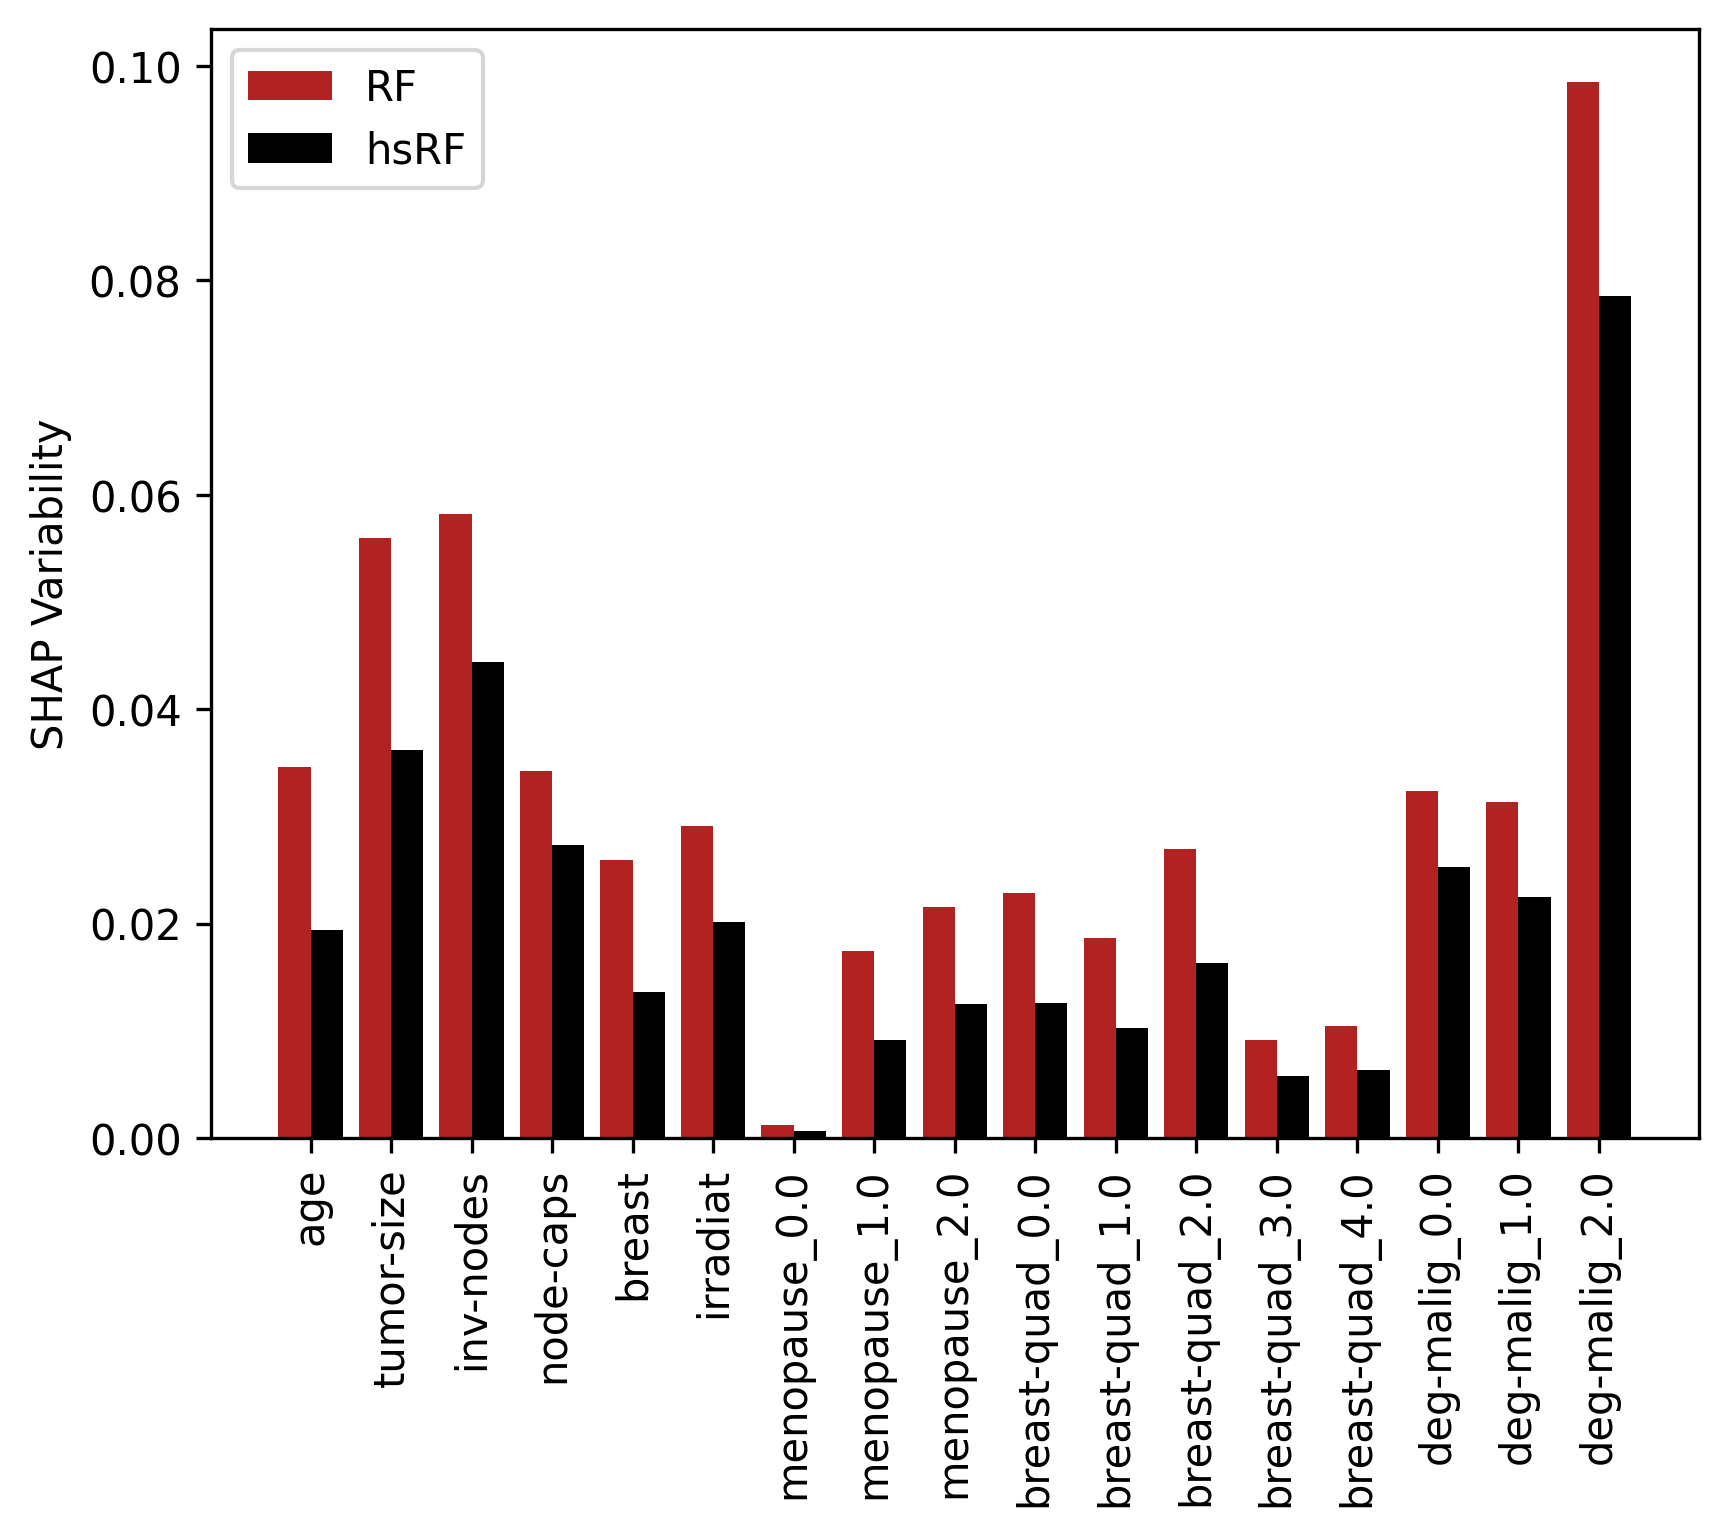

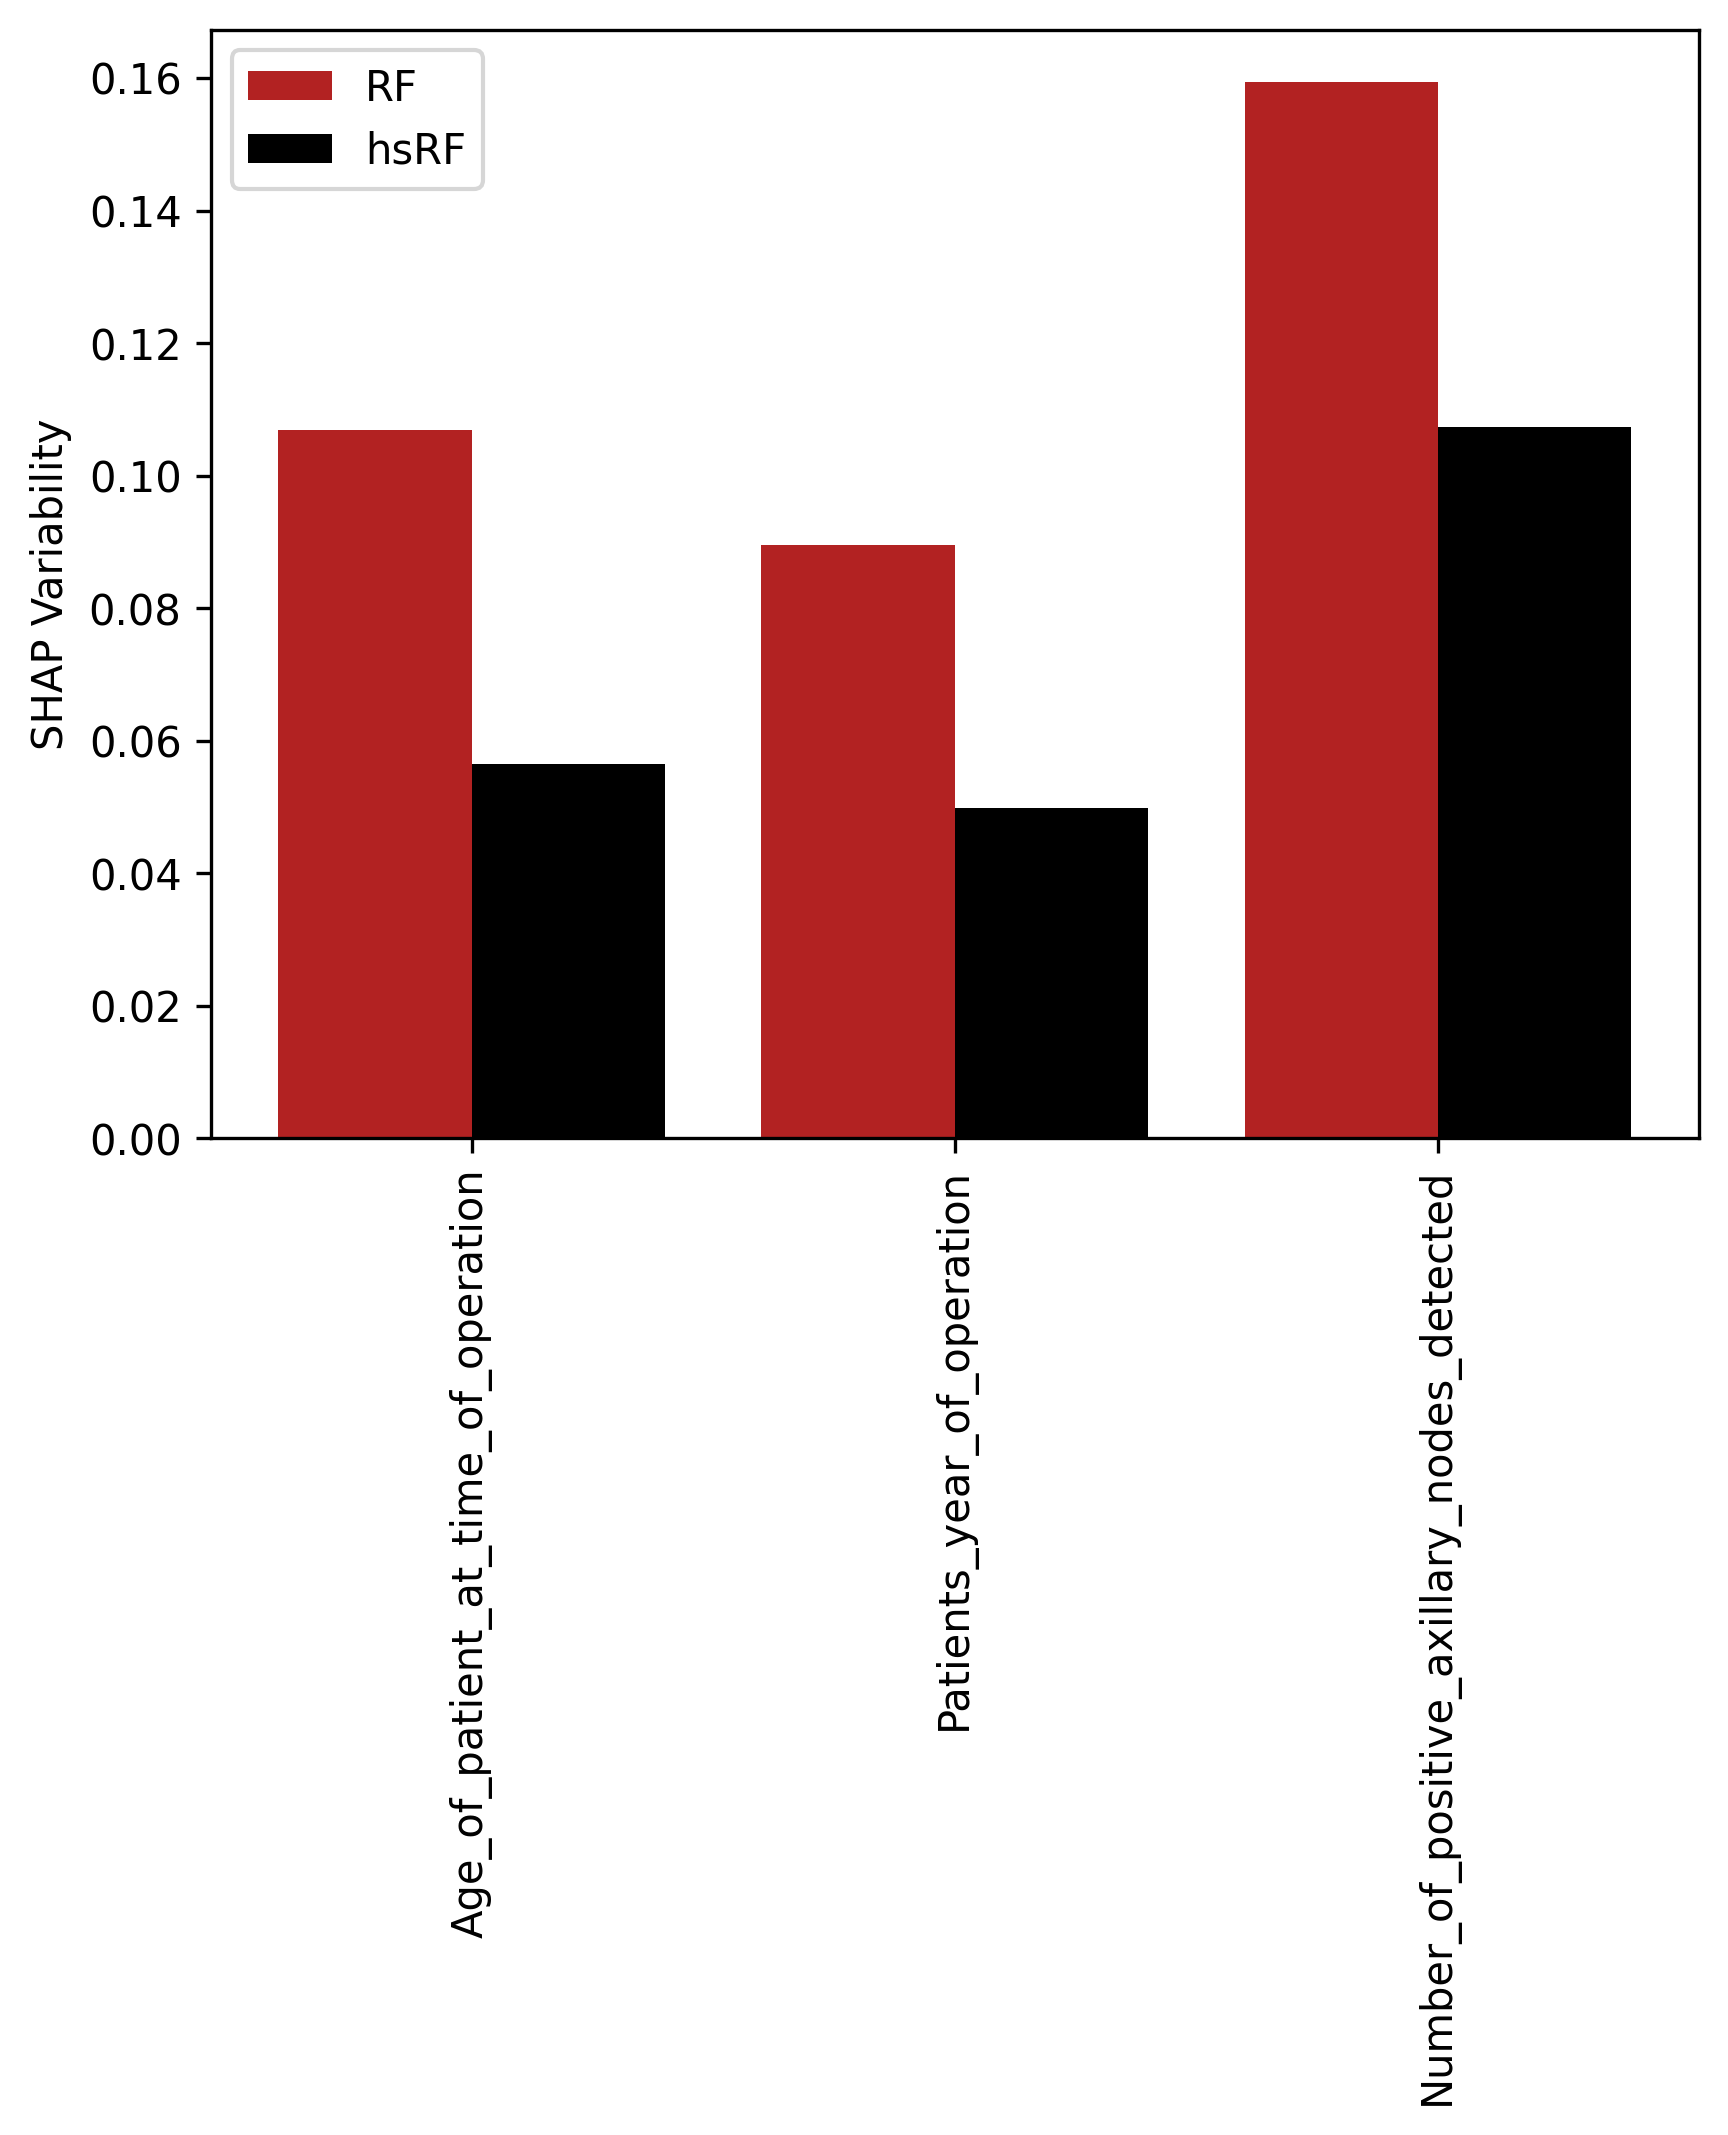

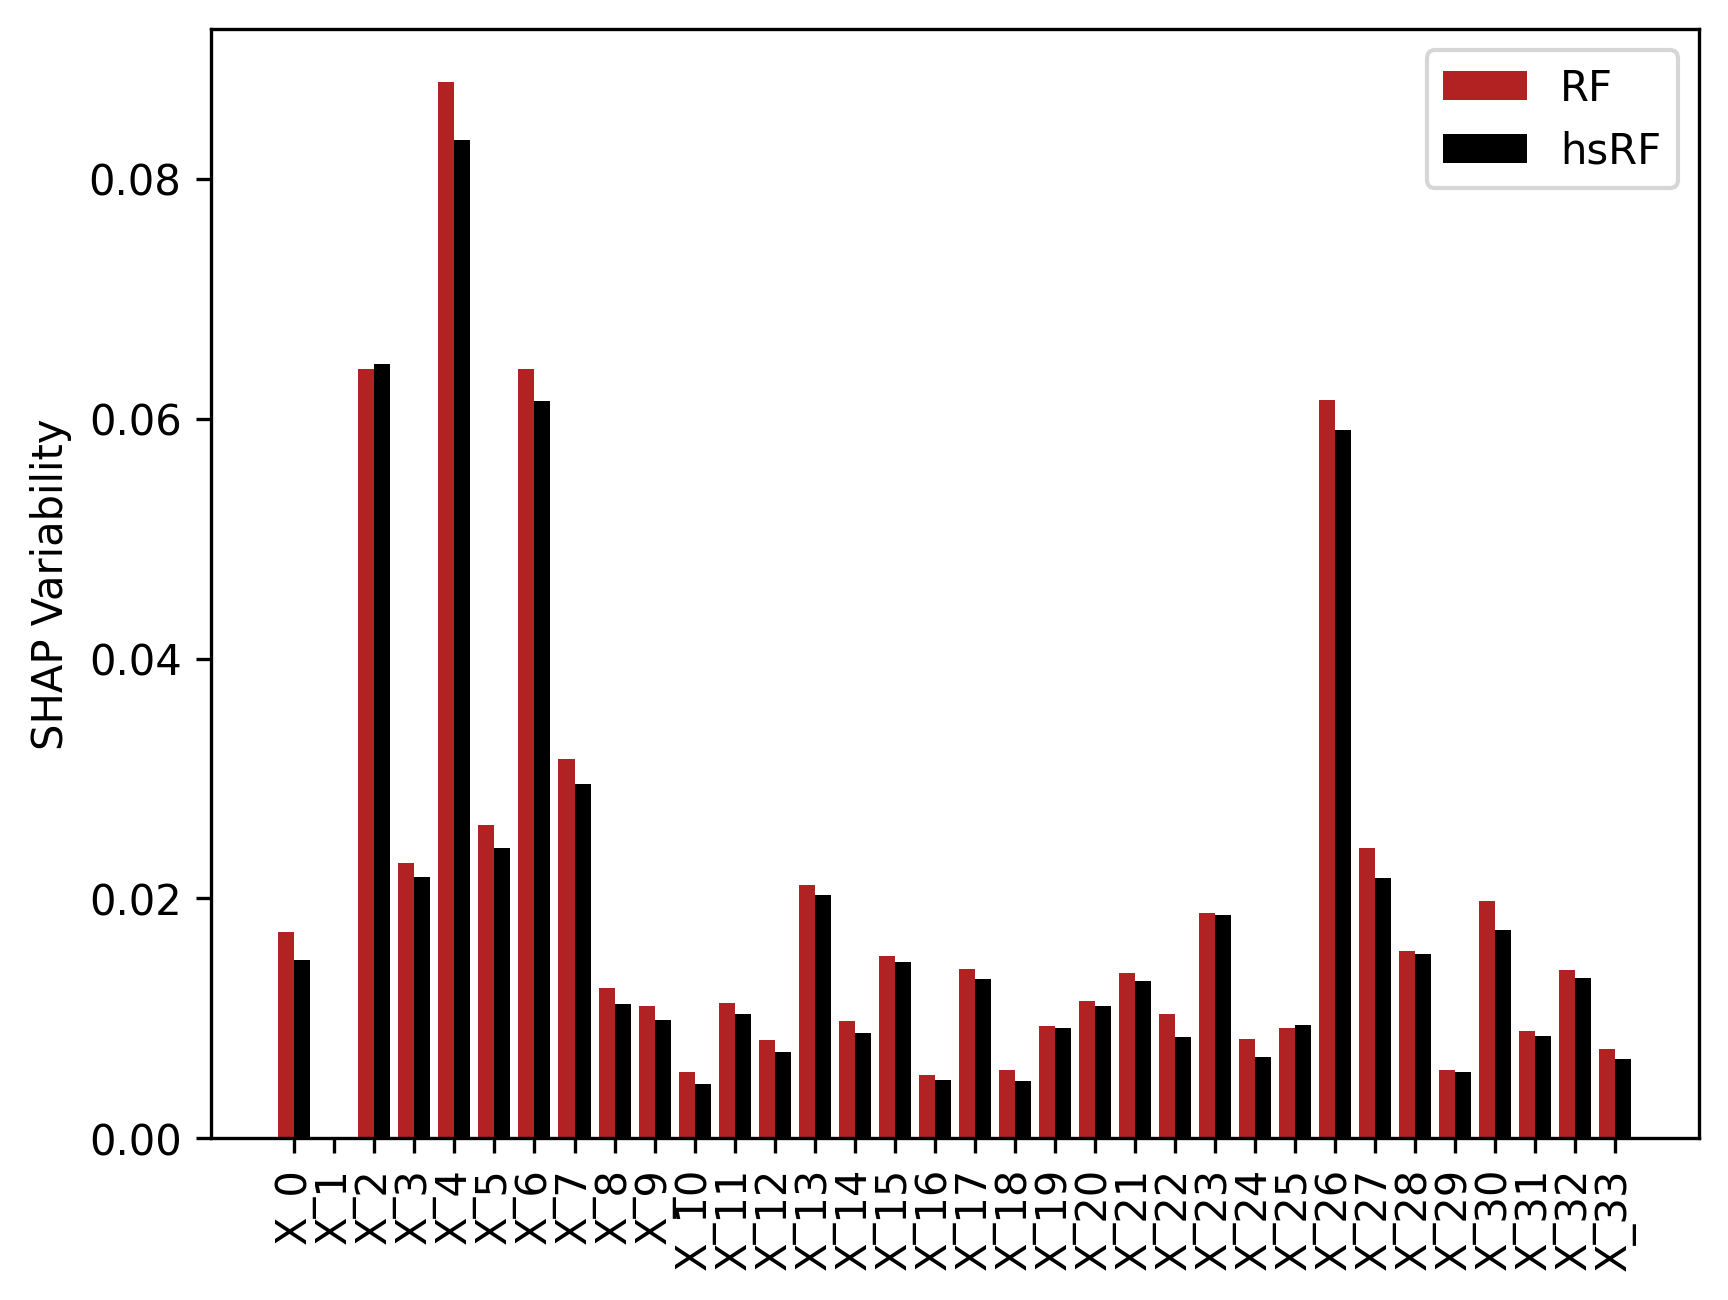

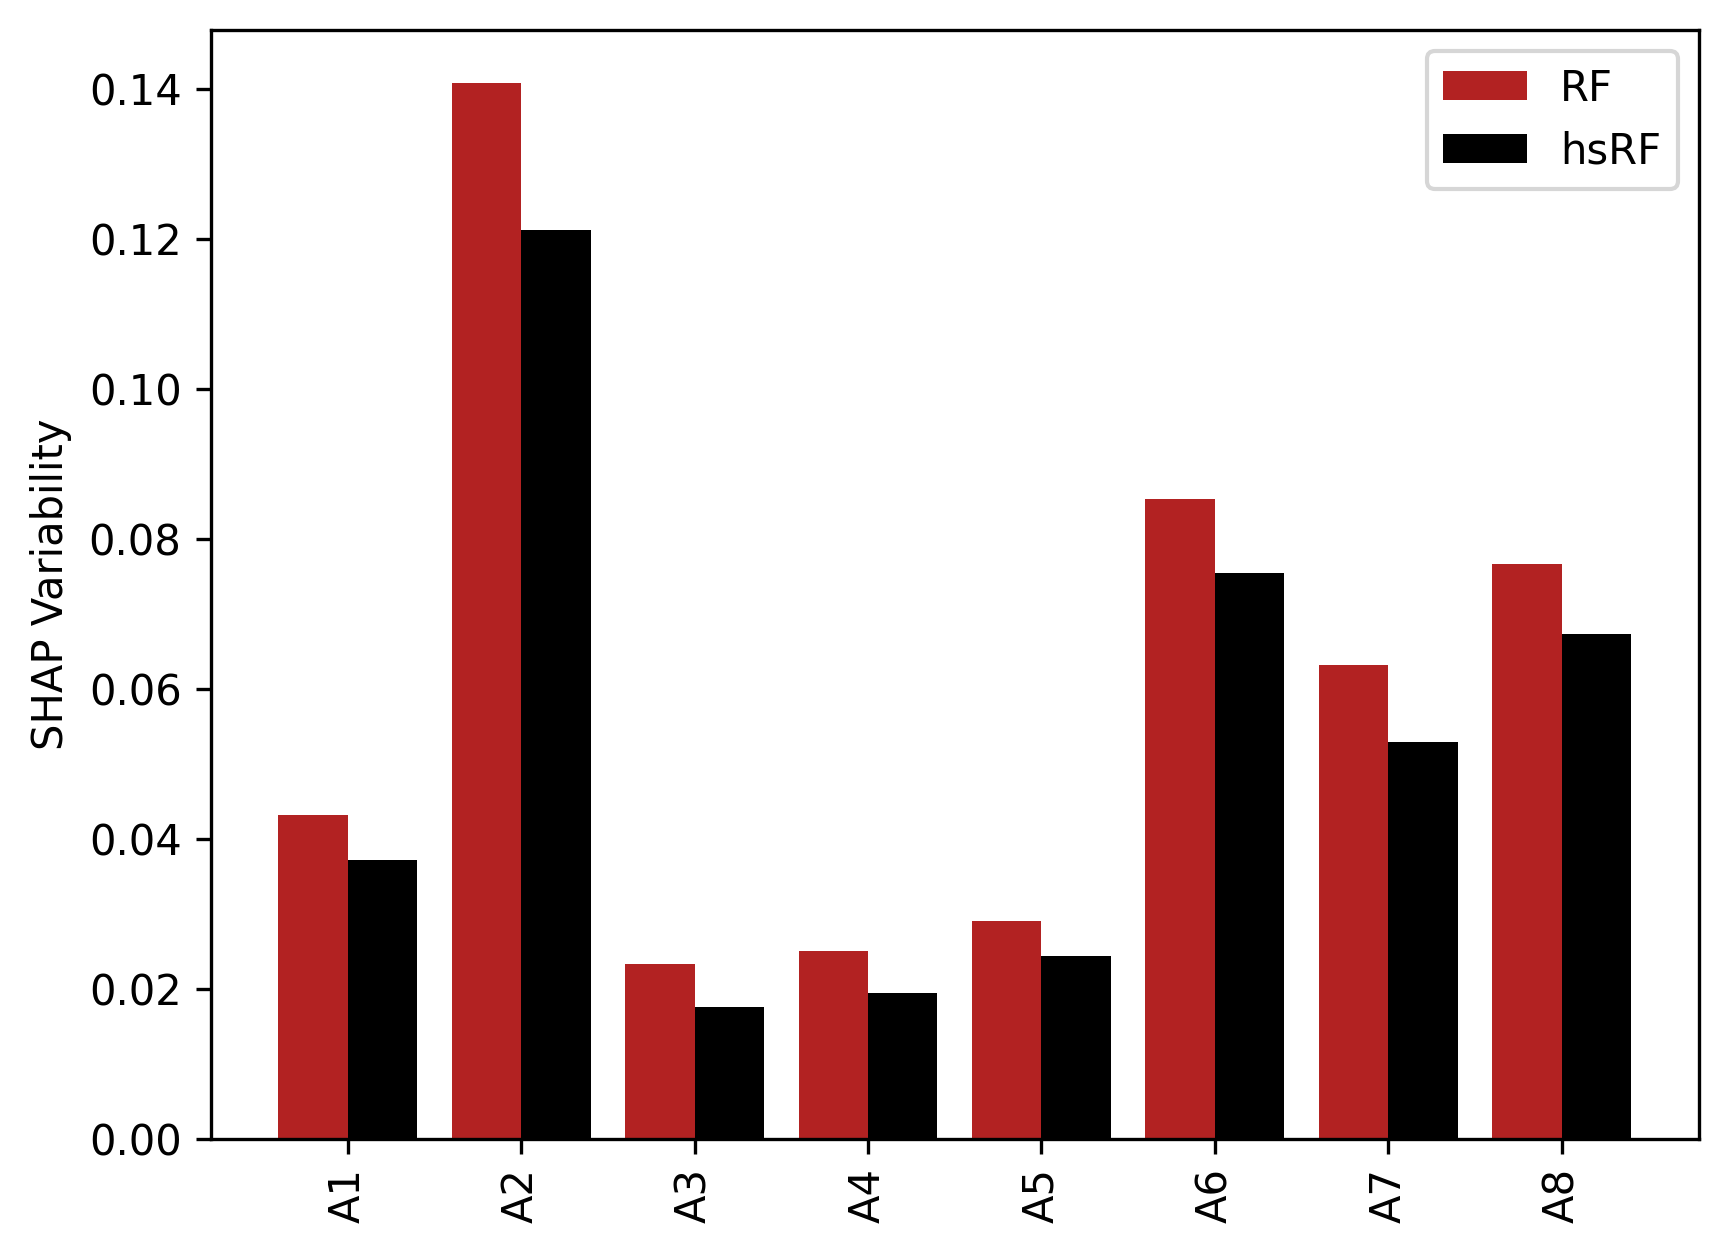

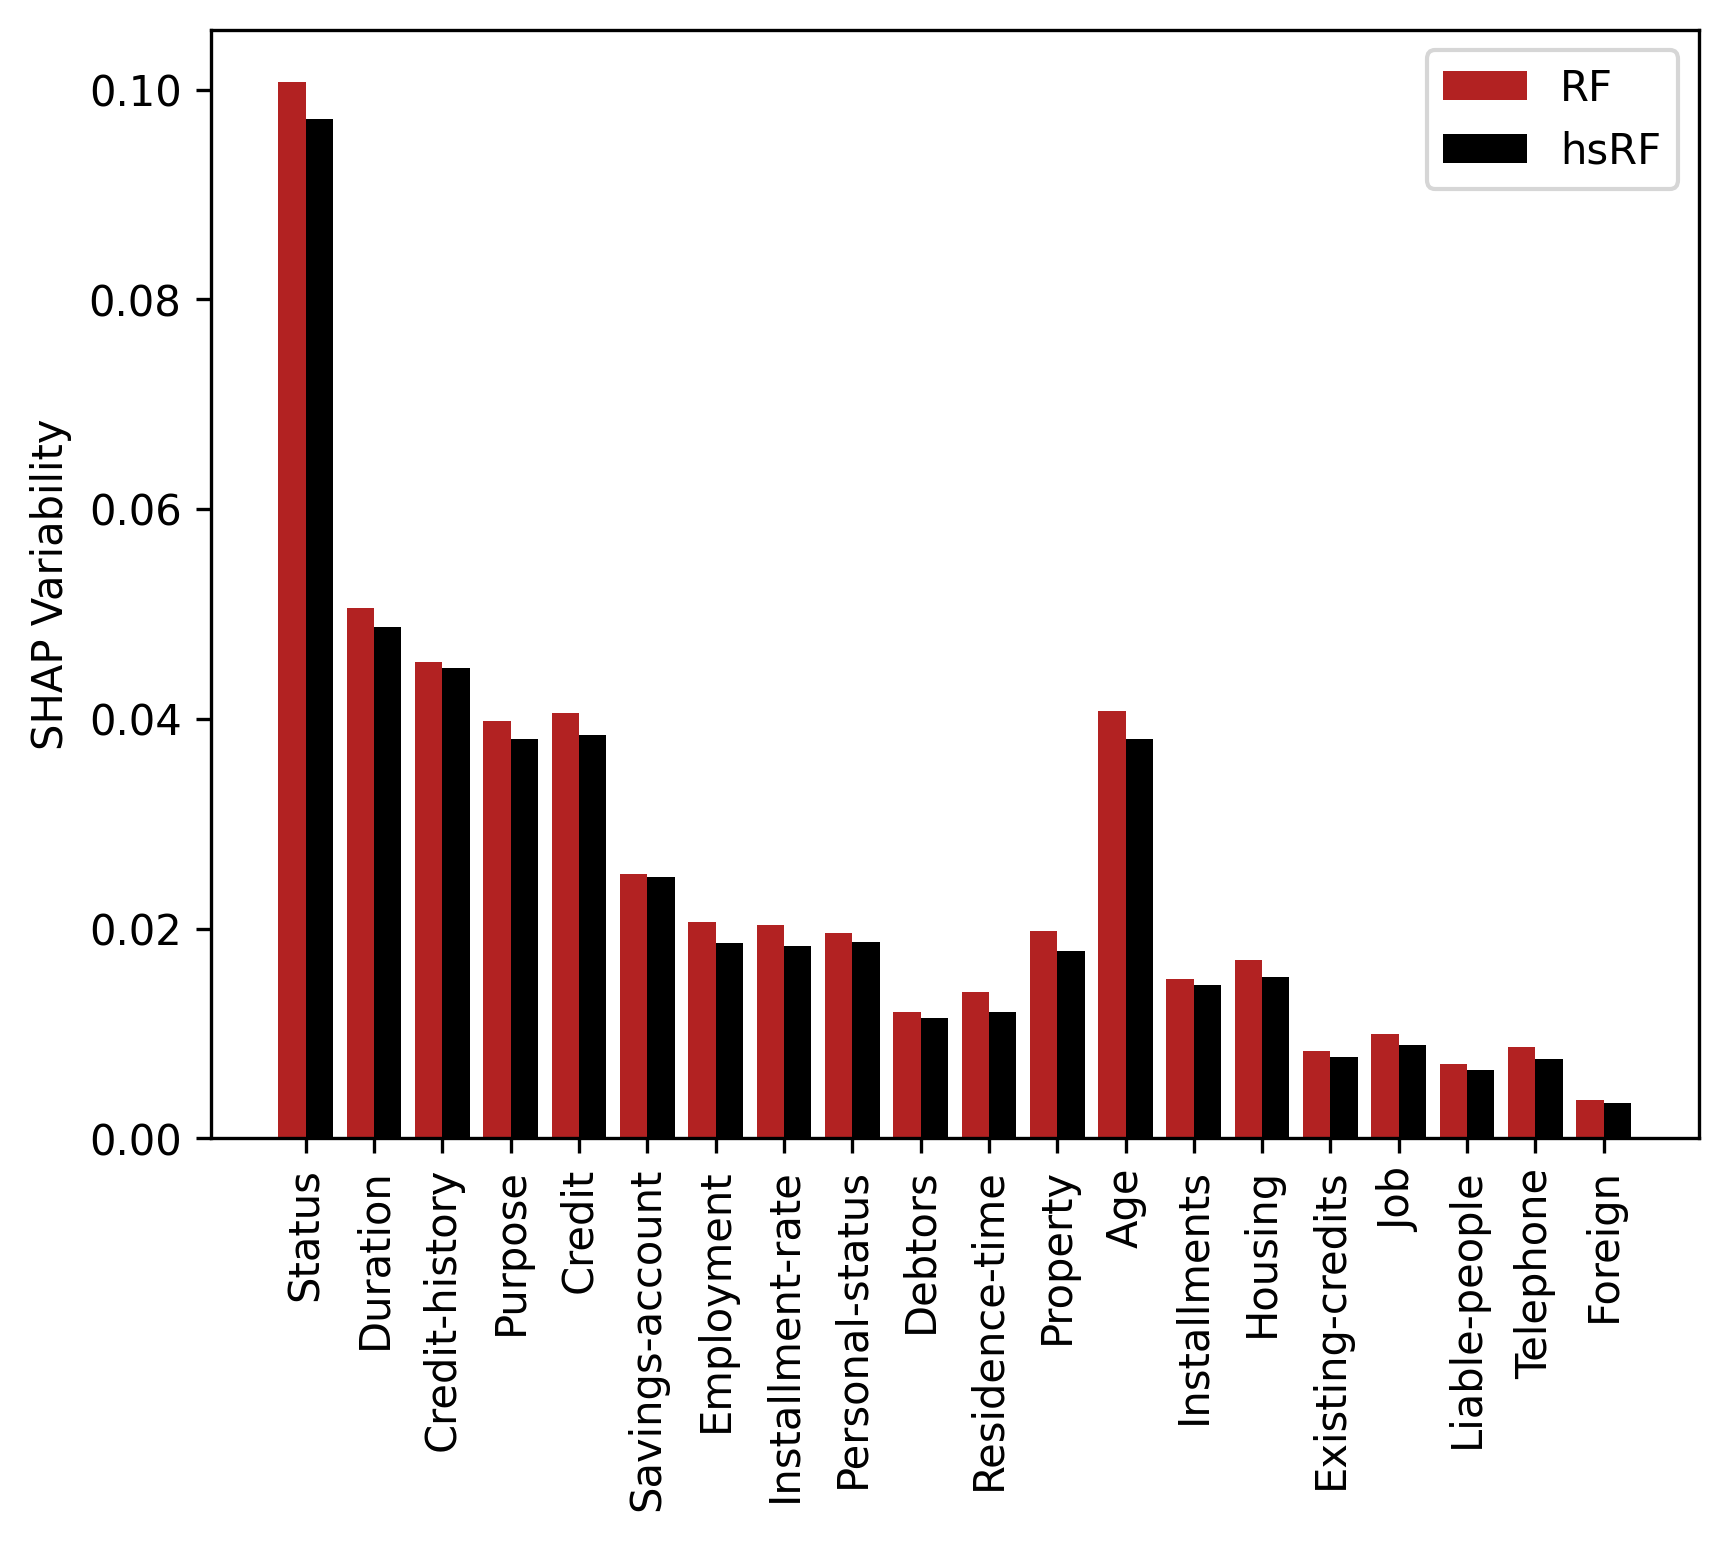

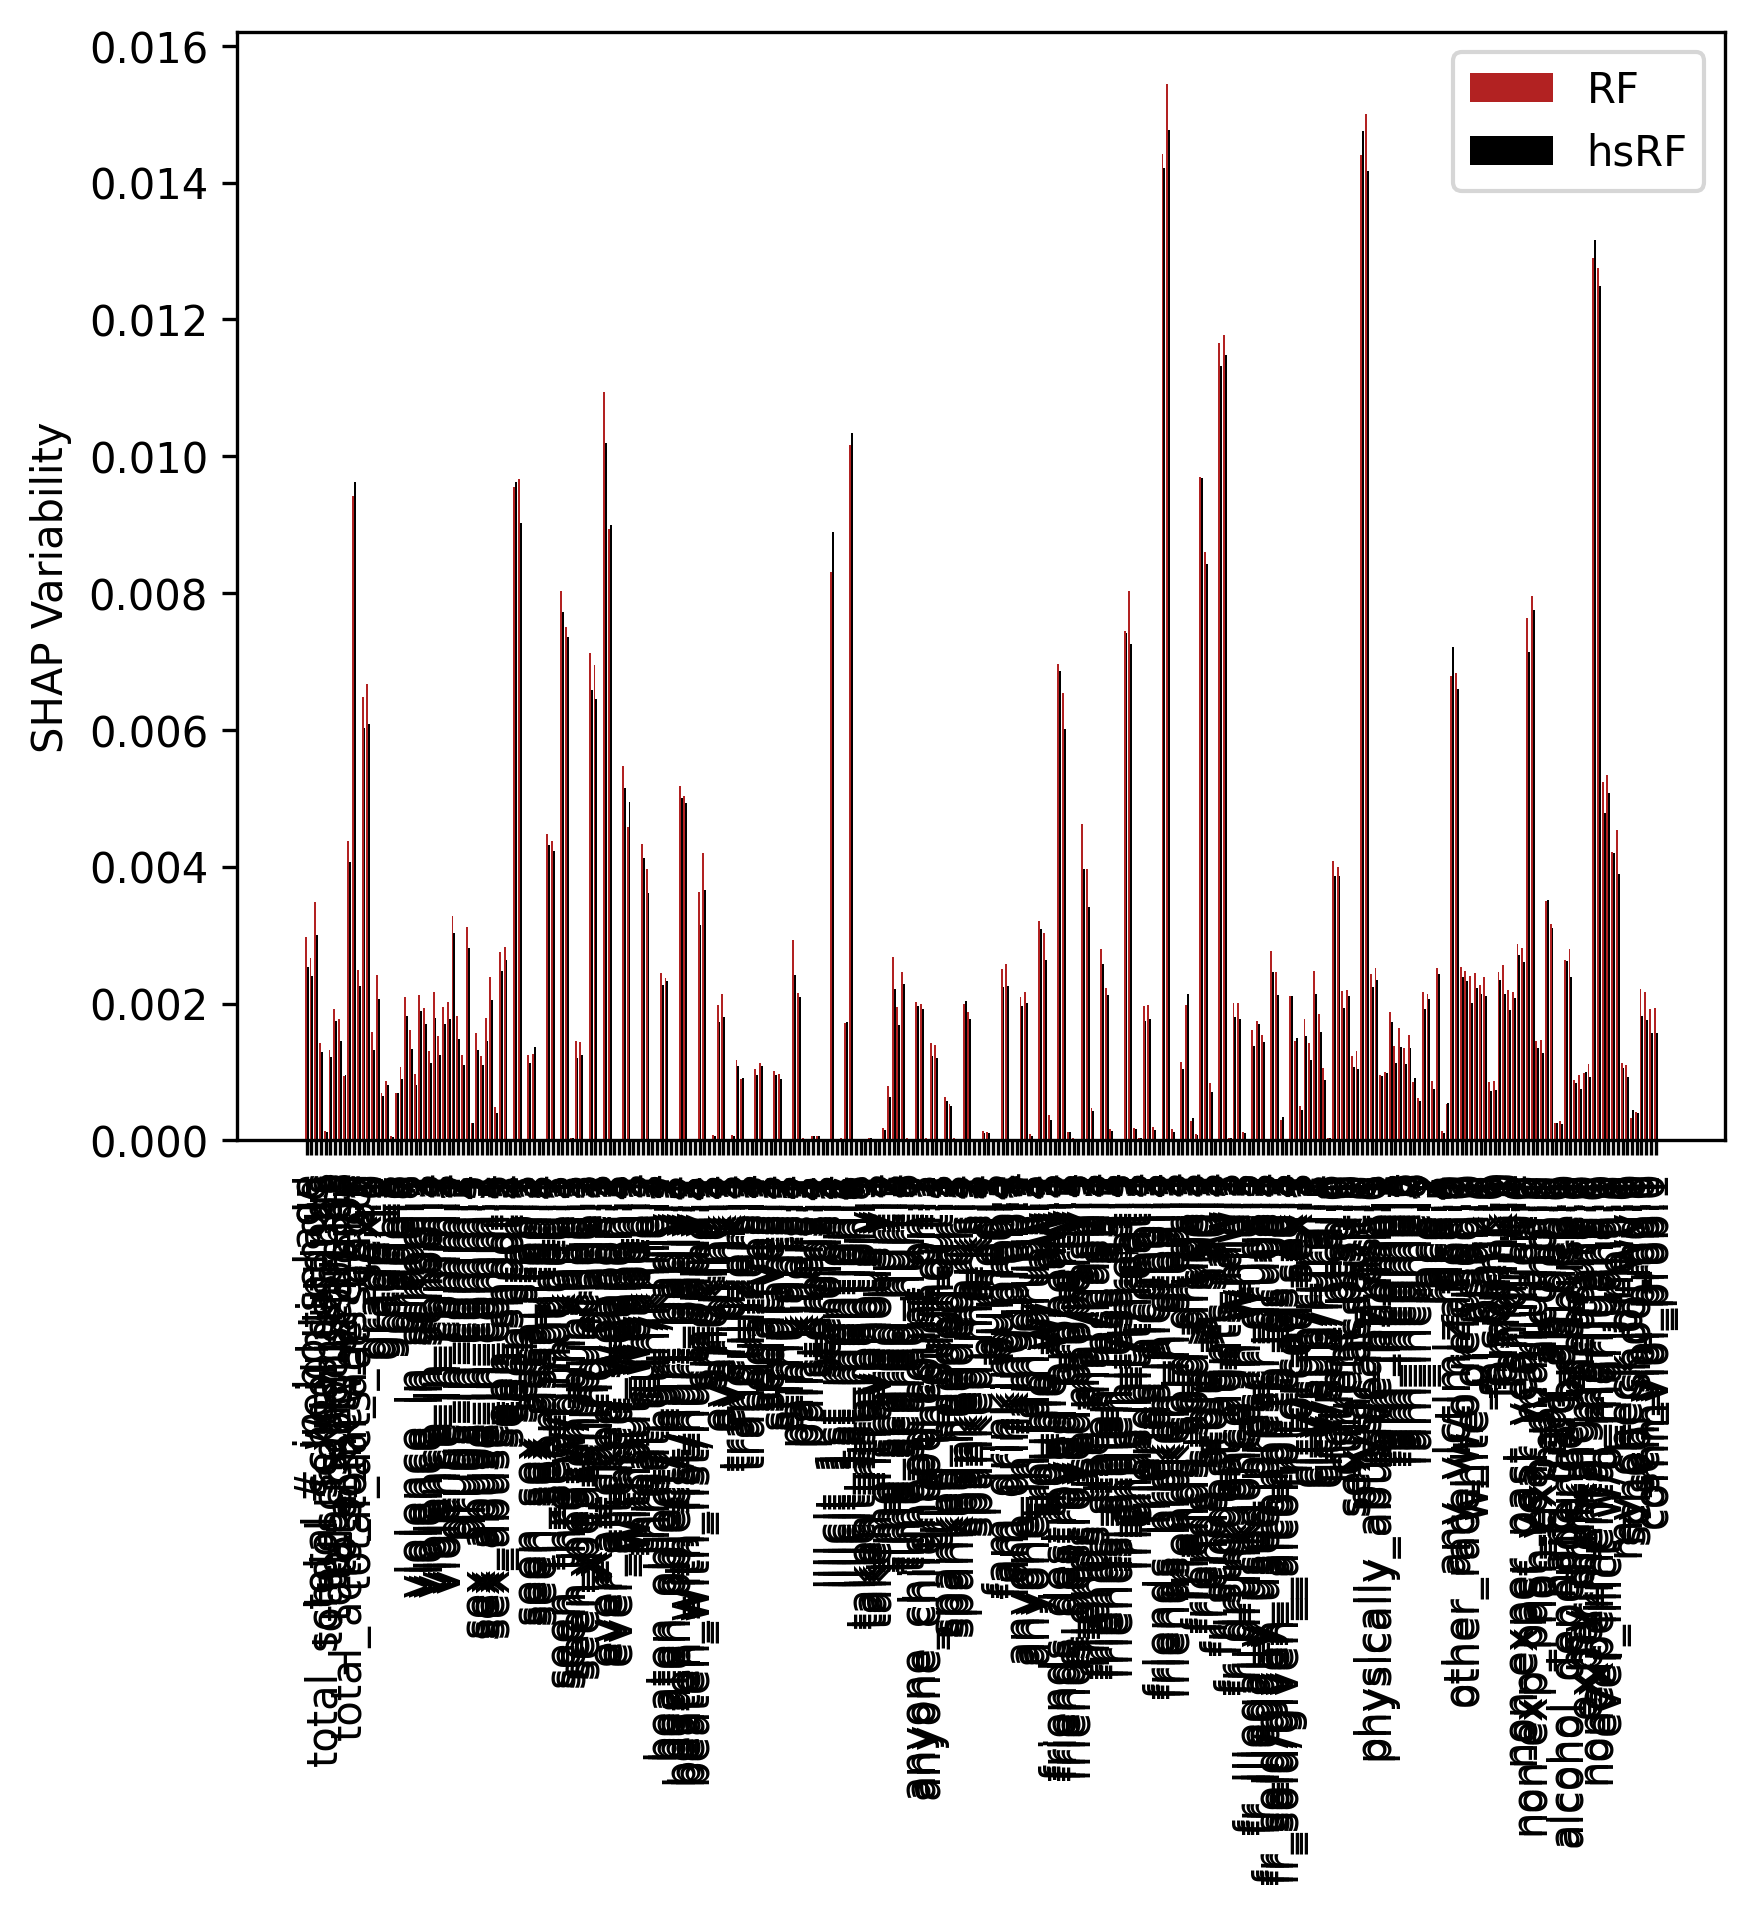

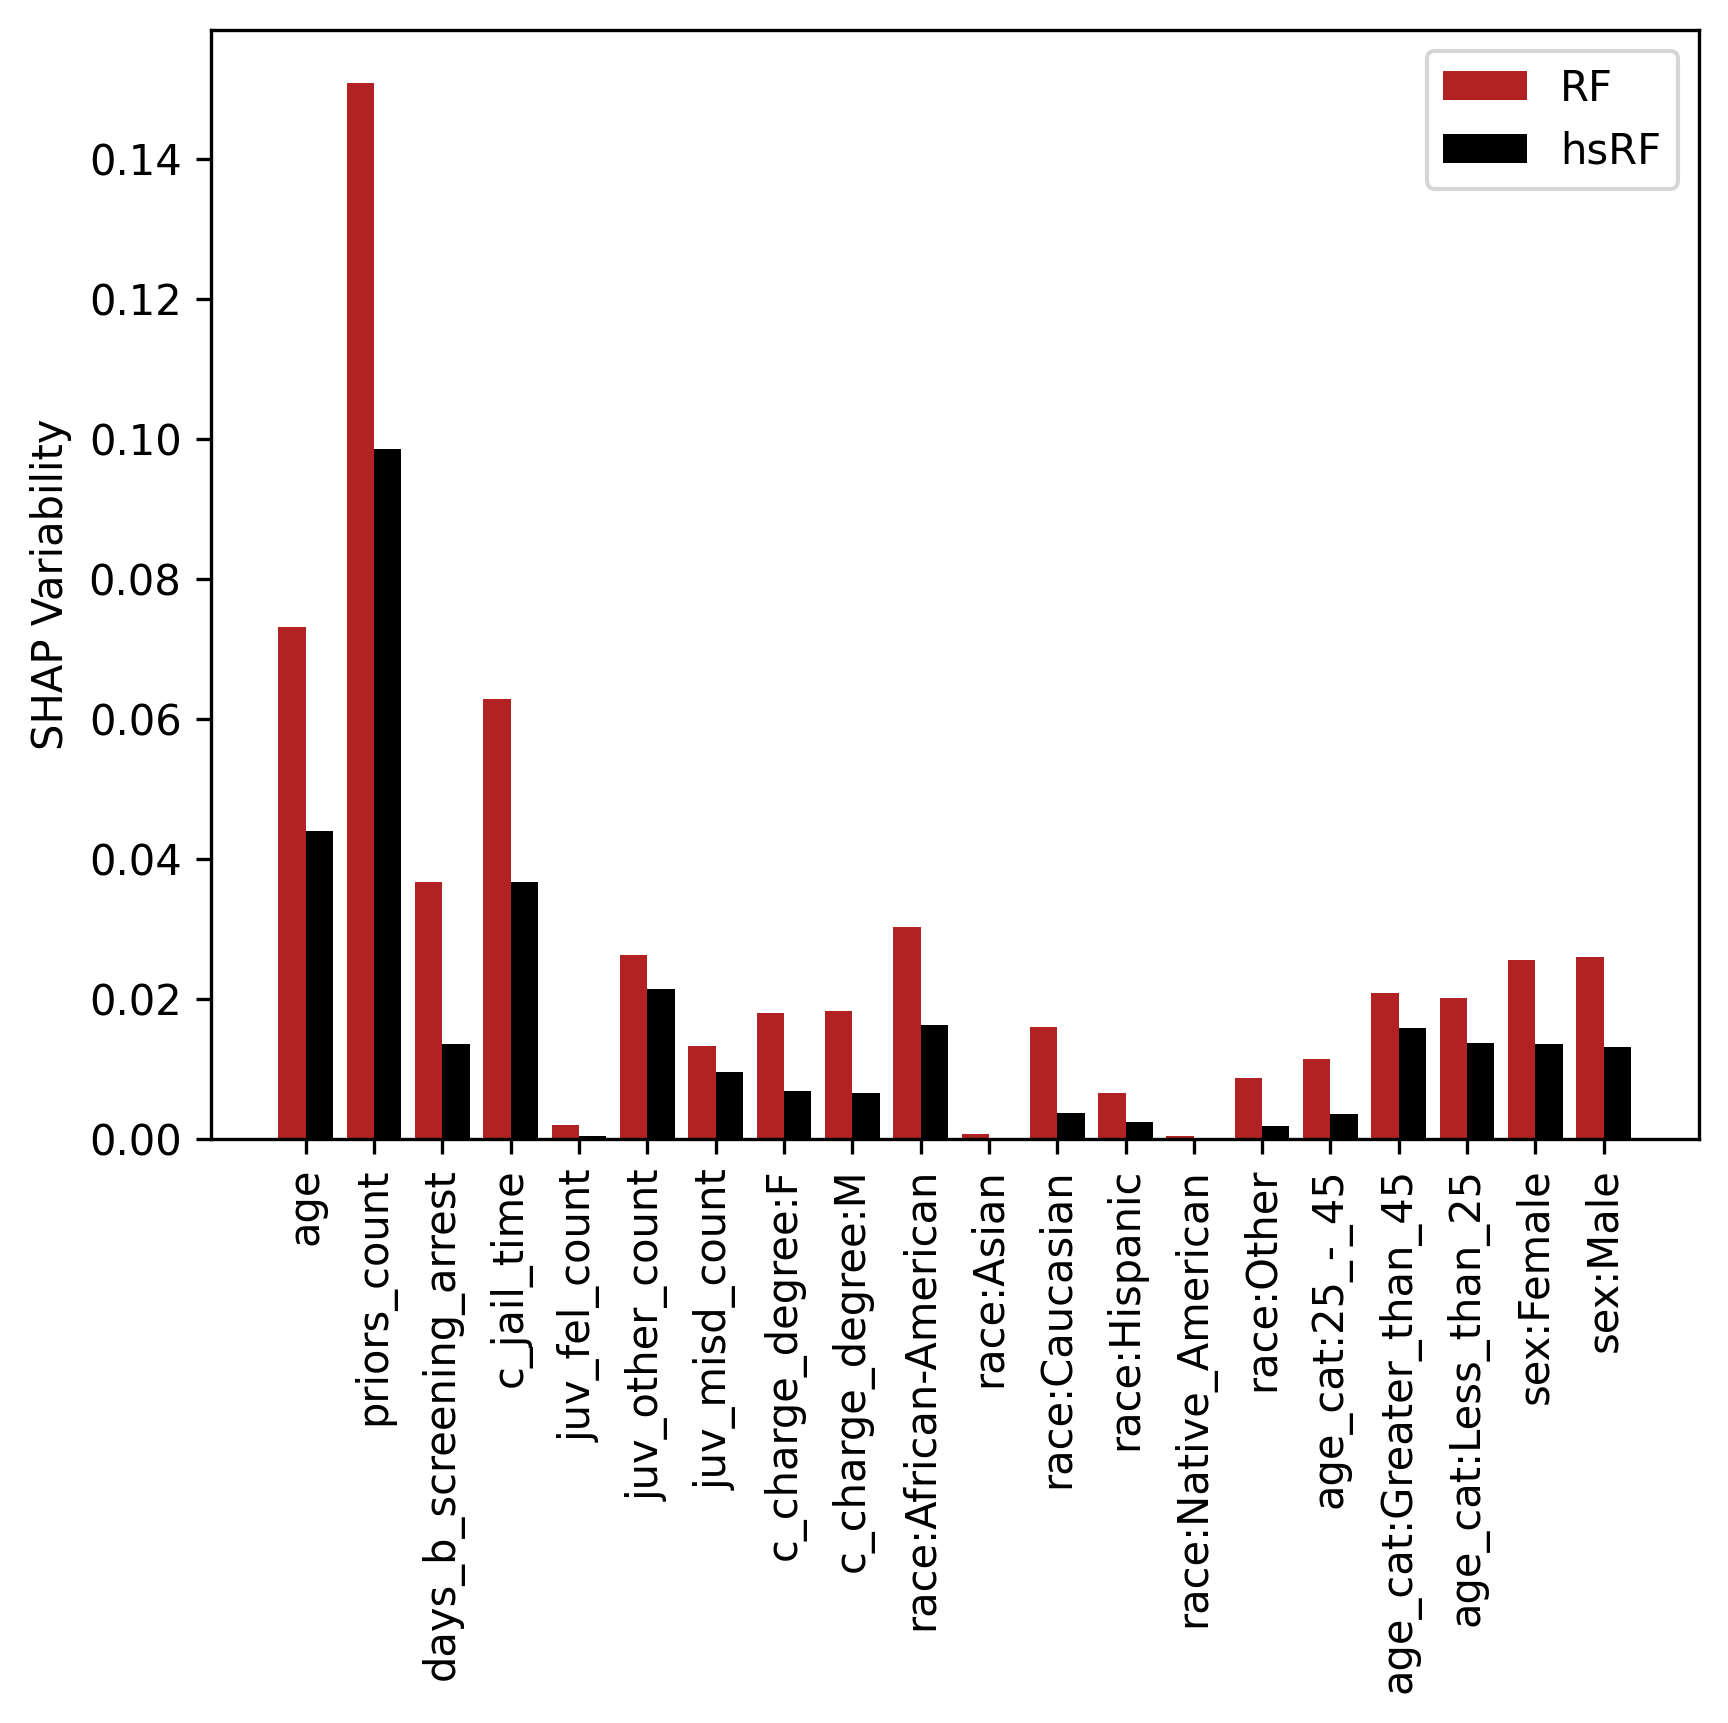

In [69]:
from datasets import DATASETS_CLASSIFICATION

for (dataset_name, database_name) in DATASETS_CLASSIFICATION.values():
    feature_variability(dataset_name, database_name, save=True)